## 3.4. Part 3: Singular Value Decomposition (SVD) for Collaborative Filtering


# 1.Data Preparation

In [122]:
import numpy as np
import pandas as pd
df = pd.read_csv('ratings.csv')
np.random.seed(42)

In [123]:
I1 = 2
I2 = 8860
# 1) Select items (must include I1 & I2)
other_items = (
    df.loc[~df["movieId"].isin([I1, I2]), "movieId"]
      .drop_duplicates()
      .sample(n=1598, random_state=42)
)
selected_items = pd.Index([I1, I2]).union(other_items)

# 2) Filter data to selected items
df_items = df[df["movieId"].isin(selected_items)]

# 3) Select users
selected_users = (
    df_items["userId"]
      .drop_duplicates()
      .sample(n=16000, random_state=42)
)

# 4) Final dataset
df_sample = df_items[df_items["userId"].isin(selected_users)]

# 5) Checks
print("Users   :", df_sample["userId"].nunique())
print("Items   :", df_sample["movieId"].nunique())
print("Ratings :", df_sample.shape[0])

Users   : 16000
Items   : 1083
Ratings : 131479


In [124]:
target_items = [I1, I2]
# Target users 
U1 = 69251
U2 = 69481
U3 = 67075
target_users = [U1, U2, U3]

print("STEP 2: Select Items (Ensure I1 & I2 Included)")
other_items = (
    df.loc[~df["movieId"].isin(target_items), "movieId"]
      .drop_duplicates()
      .sample(n=1598, random_state=42)
)
selected_items = pd.Index(target_items).union(other_items)
df_items = df[df["movieId"].isin(selected_items)]


other_users = (
    df_items.loc[~df_items["userId"].isin(target_users), "userId"]
      .drop_duplicates()
      .sample(n=16000 - len(target_users), random_state=42)
)

selected_users = pd.Index(target_users).union(other_users)

df_sample = df_items[df_items["userId"].isin(selected_users)]

print("Users   :", df_sample["userId"].nunique())
print("Items   :", df_sample["movieId"].nunique())
print("Ratings :", df_sample.shape[0])


for u in target_users:
    if u in df_sample["userId"].values:
        print(f"User {u}  EXISTS in sample")
    else:
        print(f"User {u}  NOT FOUND in sample")

# Safety check
assert all(u in df_sample["userId"].values for u in target_users), \
       "ERROR: One or more target users are missing!"

STEP 2: Select Items (Ensure I1 & I2 Included)
Users   : 16000
Items   : 1136
Ratings : 133186
User 69251  EXISTS in sample
User 69481  EXISTS in sample
User 67075  EXISTS in sample


In [125]:
I1 = 2
I2 = 8860
items_in_sample = df_sample["movieId"].unique()
print(f"I1 ({I1}) exists:", I1 in items_in_sample)
print(f"I2 ({I2}) exists:", I2 in items_in_sample)

I1 (2) exists: True
I2 (8860) exists: True


1.1 Load Ratings Matrix

In [126]:
ratings_df = df_sample.copy()
print("Ratings matrix loaded from sampled dataset")
print("Shape:", ratings_df.shape)
print(ratings_df.head())

Ratings matrix loaded from sampled dataset
Shape: (133186, 4)
     userId  movieId  rating   timestamp
0         1        2     3.5  1112486027
36        1     1215     4.0  1094786082
53        1     1333     4.0  1112484990
148       1     6539     4.0  1112485508
151       1     6774     4.0  1112485786


 1.2 Average Rating for Each Item

In [127]:
item_means = (
    ratings_df.groupby("movieId")["rating"]
    .mean()
    .astype(np.float32)
)
print("Average rating calculated for each item")
print("Number of items:", item_means.shape[0])
print(item_means.head())

Average rating calculated for each item
Number of items: 1136
movieId
2      3.215969
15     2.687853
33     3.142857
36     3.930758
123    4.028369
Name: rating, dtype: float32


1.3 Mean-Filling

In [128]:
R = ratings_df.pivot(
    index="userId",
    columns="movieId",
    values="rating"
)
print("Shape of R:", R.shape)

Shape of R: (16000, 1136)


In [129]:
missing_total = R.isna().sum().sum()
print("Total number of missing values:", missing_total)
#missing_per_user
missing_per_user = R.isna().sum(axis=1)
print("\nMissing values per user (first 5):")
print(missing_per_user.head())
#missing_per_item 
missing_per_item = R.isna().sum(axis=0)
print("\nMissing values per item (first 5):")
print(missing_per_item.head())

Total number of missing values: 18042814

Missing values per user (first 5):
userId
1     1130
33    1134
37    1135
42    1134
48    1130
dtype: int64

Missing values per item (first 5):
movieId
2      13157
15     15646
33     15993
36     13321
123    15718
dtype: int64


In [130]:
R_filled = R.fillna(item_means)
print("Mean-filling applied successfully")

Mean-filling applied successfully


In [131]:
missing_total = R_filled.isna().sum().sum()
print("Total number of missing values after mean-filling:", missing_total)
#missing_per_user
missing_per_user = R_filled.isna().sum(axis=1)
print("\nMissing values per user (first 5):")
print(missing_per_user.head())
#missing_per_item 
missing_per_item = R_filled.isna().sum(axis=0)
print("\nMissing values per item (first 5):")
print(missing_per_item.head())

Total number of missing values after mean-filling: 0

Missing values per user (first 5):
userId
1     0
33    0
37    0
42    0
48    0
dtype: int64

Missing values per item (first 5):
movieId
2      0
15     0
33     0
36     0
123    0
dtype: int64


1.4: Verify Matrix Completeness

In [132]:
missing_after = R_filled.isna().sum().sum()
if missing_after == 0:
    print(" Matrix is complete: no missing values")
else:
    print(" Matrix is not complete")

 Matrix is complete: no missing values


# 2. Full SVD Decomposition

**2.1: Compute the full SVD: R = U Σ V^T**

In [133]:
# Prepare matrix R
R = R_filled.values.astype(np.float64)
m, n = R.shape
r = min(m, n)
print(f"Matrix dimensions: m={m}, n={n}")

Matrix dimensions: m=16000, n=1136


## 2.2: Calculate and save eigenpairs (λi, vi)

In [134]:
RtR = R.T @ R
eigenvalues, V = np.linalg.eigh(RtR)
# Sort in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
V = V[:, idx]
print("\nTop 10 Eigenvalues:")
print(eigenvalues[:10])


Top 10 Eigenvalues:
[1.91362547e+08 5.04274197e+03 3.70950670e+03 3.12584135e+03
 2.62777389e+03 2.44374216e+03 2.31252020e+03 2.24502605e+03
 2.16557077e+03 2.05827142e+03]


**Compute all singular values → build Σ**

In [135]:
# Singular values σi = sqrt(λi)
sigma = np.sqrt(np.maximum(eigenvalues, 0))
Sigma = np.diag(sigma)
print("\nTop 10 Singular Values:")
print(sigma[:10])
print(f"Sigma shape: {Sigma.shape}")


Top 10 Singular Values:
[13833.38523847    71.01226633    60.9057198     55.90922422
    51.26181712    49.43422051    48.08867022    47.38170583
    46.53569354    45.36817629]
Sigma shape: (1136, 1136)


 Normalize vi → build V (orthonormal)

In [136]:
# Normalize eigenvectors
V_hat = V / np.linalg.norm(V, axis=0)
print(f"V_hat shape: {V_hat.shape}")

V_hat shape: (1136, 1136)


Calculate ui = (R vi) / σi → build U

In [137]:
U = np.zeros((m, r))
for i in range(r):
    if sigma[i] > 1e-10:
        U[:, i] = (R @ V_hat[:, i]) / sigma[i]
print(f"U shape: {U.shape}")

U shape: (16000, 1136)


**Verify orthogonality (U^T U = I, V^T V = I)**

In [138]:
#  Orthogonal / Orthonormal Check
tol = 1e-8
def simple_check(Q, tol=1e-8):
    QtQ = Q.T @ Q
    off_diag = QtQ - np.diag(np.diag(QtQ))
    diag = np.diag(QtQ)

    is_orthogonal = np.linalg.norm(off_diag) < tol
    is_orthonormal = is_orthogonal and np.linalg.norm(diag - 1) < tol

    return is_orthogonal, is_orthonormal

# Check U
ortho_U, orthonorm_U = simple_check(U)
print("U:")
print("Orthogonal  ", ortho_U)
print("Orthonormal  ", orthonorm_U)

# Check V
ortho_V, orthonorm_V = simple_check(V_hat)
print("\nV:")
print("Orthogonal   ", ortho_V)
print("Orthonormal  ", orthonorm_V)

U:
Orthogonal   False
Orthonormal   False

V:
Orthogonal    True
Orthonormal   True


## QR Re-Orthogonalization 

In [139]:
U_qr, _ = np.linalg.qr(U)
print("\nU_qr shape:", U_qr.shape)

# STEP 2.5: Final True / False Check (After QR)
print("CHECK AFTER QR")

ortho_U_qr, orthonorm_U_qr = simple_check(U_qr)
print("U after QR:")
print("Orthogonal  ", ortho_U_qr)
print("Orthonormal  ", orthonorm_U_qr)

print("\nV (unchanged):")
print("Orthogonal    ", ortho_V)
print("Orthonormal ", orthonorm_V)


U_qr shape: (16000, 1136)
CHECK AFTER QR
U after QR:
Orthogonal   True
Orthonormal   True

V (unchanged):
Orthogonal     True
Orthonormal  True


In [140]:
R_reconstructed = U @ Sigma @ V_hat.T
reconstruction_error = np.linalg.norm(R - R_reconstructed, 'fro')
print(f"Reconstruction Error (Frobenius norm): {reconstruction_error:.6e}")
print(f"Full SVD completed successfully" if reconstruction_error < 1e-6 else " High reconstruction error")

Reconstruction Error (Frobenius norm): 5.140950e-07
Full SVD completed successfully


## Visualization


Creating Visualizations for Full SVD


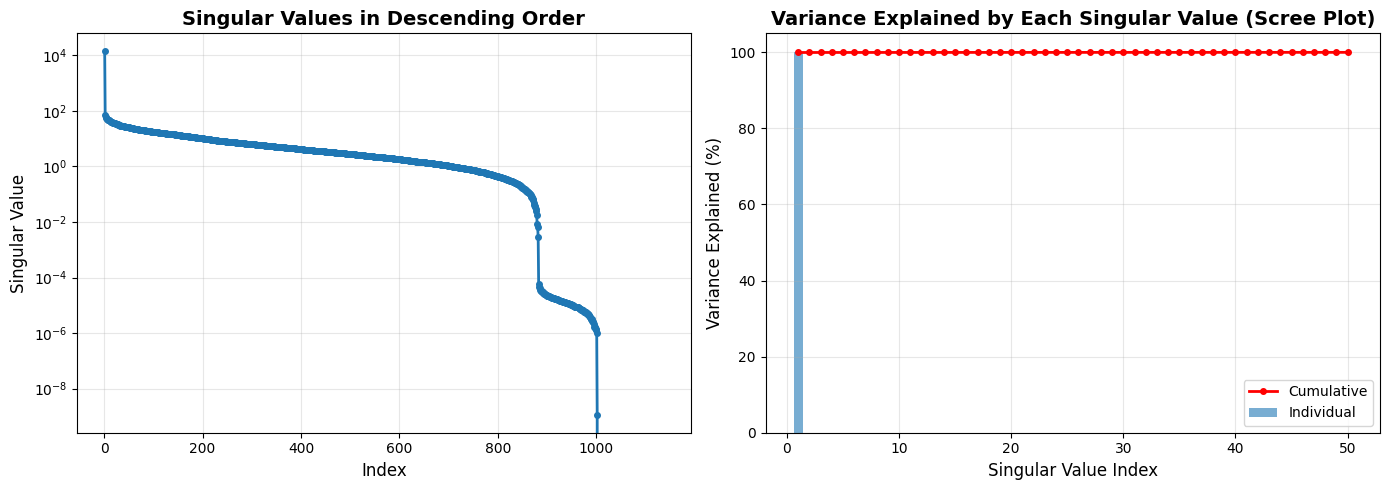

In [141]:
#  Visualize Singular Values
import matplotlib.pyplot as plt
print("\nCreating Visualizations for Full SVD")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Singular values in descending order
axes[0].plot(range(1, len(sigma)+1), sigma, marker='o', linewidth=2, markersize=4)
axes[0].set_xlabel('Index', fontsize=12)
axes[0].set_ylabel('Singular Value', fontsize=12)
axes[0].set_title('Singular Values in Descending Order', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')
# Plot 2: Scree plot (variance explained by each singular value)
variance_explained = (sigma**2) / np.sum(sigma**2) * 100
cumulative_variance = np.cumsum(variance_explained)
axes[1].bar(range(1, min(51, len(sigma)+1)), variance_explained[:50], alpha=0.6, label='Individual')
axes[1].plot(range(1, min(51, len(sigma)+1)), cumulative_variance[:50], 
             color='red', marker='o', linewidth=2, markersize=4, label='Cumulative')
axes[1].set_xlabel('Singular Value Index', fontsize=12)
axes[1].set_ylabel('Variance Explained (%)', fontsize=12)
axes[1].set_title('Variance Explained by Each Singular Value (Scree Plot)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Truncated SVD 

3.1: Truncated SVD for different k

In [142]:
#  TRUNCATED SVD (LOW-RANK APPROXIMATION)
k_values = [5, 20, 50, 100]
results = {
    'k': [],
    'MAE': [],
    'RMSE': [],
}
total_variance = np.sum(sigma**2)

3.2 Truncated SVD Construction for Each k
3.3: Reconstruction Error (MAE & RMSE)

In [143]:
for k in k_values:
    print(f"k = {k} ")
    
     #Construct Truncated Matrices
    U_k = U[:, :k]              # First k columns of U
    sigma_k = sigma[:k]         # First k singular values
    Sigma_k = np.diag(sigma_k)  # k×k diagonal matrix
    V_k = V_hat[:, :k]          # First k columns of V
    
    print(f"U_k shape: {U_k.shape}")
    print(f"Σ_k shape: {Sigma_k.shape}")
    print(f"V_k shape: {V_k.shape}")
    
    #  Compute Approximation R̂_k
    R_approx = U_k @ Sigma_k @ V_k.T
    print(f"R_approx shape: {R_approx.shape}")

    #  Calculate Reconstruction Errors
    diff = R - R_approx
    # Mean Absolute Error
    mae = np.mean(np.abs(diff))
    # Root Mean Square Error
    rmse = np.sqrt(np.mean(diff**2))
    # Variance retained
    variance_retained = np.sum(sigma_k**2) / total_variance * 100
    
    # Store results
    results['k'].append(k)
    results['MAE'].append(mae)
    results['RMSE'].append(rmse)

    
    print(f"\nReconstruction Errors:")
    print(f"  MAE:                {mae:.4f}")
    print(f"  RMSE:               {rmse:.4f}")
    print(f"  Variance Retained:  {variance_retained:.2f}%")

k = 5 
U_k shape: (16000, 5)
Σ_k shape: (5, 5)
V_k shape: (1136, 5)
R_approx shape: (16000, 1136)

Reconstruction Errors:
  MAE:                0.0086
  RMSE:               0.0766
  Variance Retained:  99.94%
k = 20 
U_k shape: (16000, 20)
Σ_k shape: (20, 20)
V_k shape: (1136, 20)
R_approx shape: (16000, 1136)

Reconstruction Errors:
  MAE:                0.0081
  RMSE:               0.0662
  Variance Retained:  99.96%
k = 50 
U_k shape: (16000, 50)
Σ_k shape: (50, 50)
V_k shape: (1136, 50)
R_approx shape: (16000, 1136)

Reconstruction Errors:
  MAE:                0.0076
  RMSE:               0.0538
  Variance Retained:  99.97%
k = 100 
U_k shape: (16000, 100)
Σ_k shape: (100, 100)
V_k shape: (1136, 100)
R_approx shape: (16000, 1136)

Reconstruction Errors:
  MAE:                0.0067
  RMSE:               0.0409
  Variance Retained:  99.98%


**3.4: Visualization**

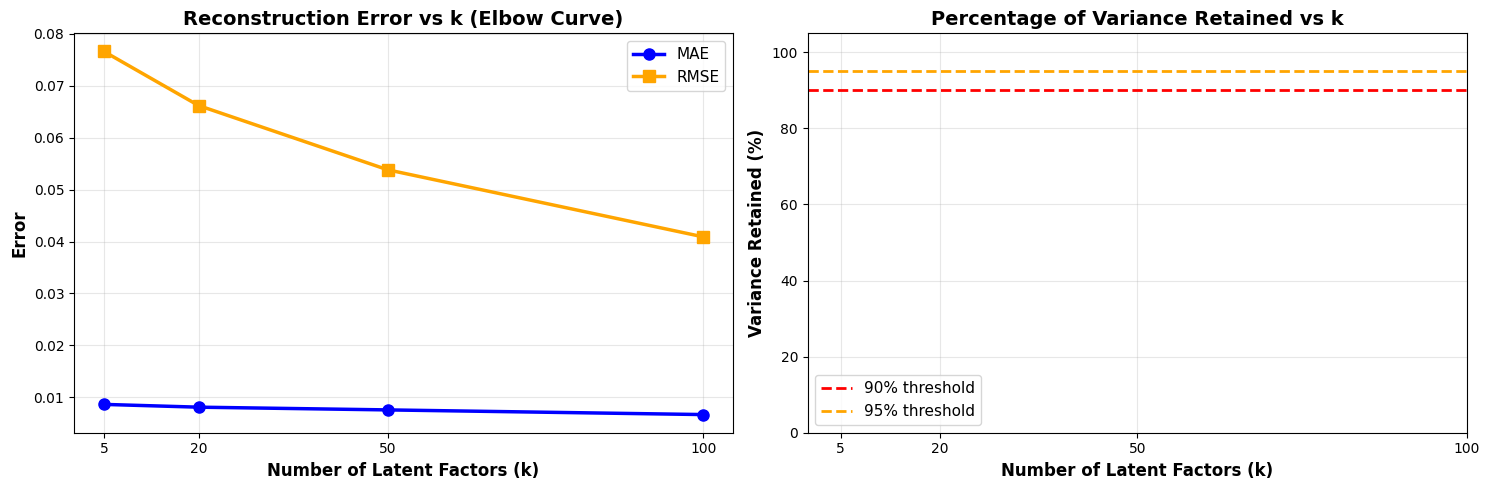

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Reconstruction Error vs k (Elbow Curve)
axes[0].plot(results['k'], results['MAE'], marker='o', linewidth=2.5, 
             markersize=8, label='MAE', color='blue')
axes[0].plot(results['k'], results['RMSE'], marker='s', linewidth=2.5, 
             markersize=8, label='RMSE', color='orange')
axes[0].set_xlabel('Number of Latent Factors (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Error', fontsize=12, fontweight='bold')
axes[0].set_title('Reconstruction Error vs k (Elbow Curve)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(results['k'])

# Plot 2: Variance Retained vs k
axes[1].axhline(y=90, color='red', linestyle='--', linewidth=2, label='90% threshold')
axes[1].axhline(y=95, color='orange', linestyle='--', linewidth=2, label='95% threshold')
axes[1].set_xlabel('Number of Latent Factors (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Variance Retained (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Percentage of Variance Retained vs k', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(results['k'])
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.show()

**3.4Identify OPTIMAL k (Elbow Method)**


RMSE rate of change:
  k=5 → k=20: -0.0104
  k=20 → k=50: -0.0124
  k=50 → k=100: -0.0129

✓ Suggested optimal k (elbow method): 50
  - RMSE: 0.0538


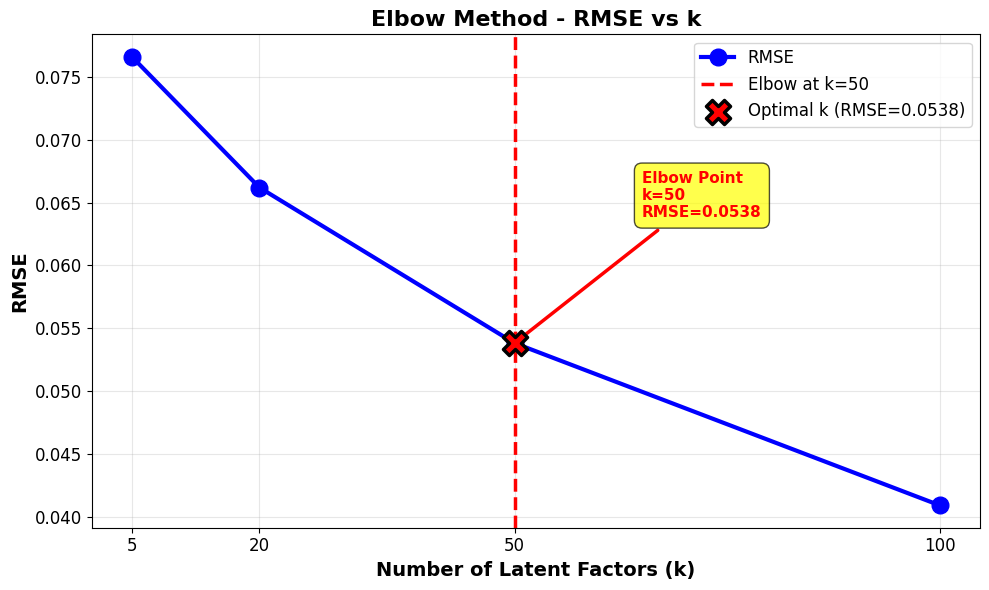

In [145]:
import matplotlib.pyplot as plt

# Calculate rate of change in RMSE
rmse_changes = np.diff(results['RMSE'])
print("\nRMSE rate of change:")
for i, k in enumerate(results['k'][1:], 1):
    print(f"  k={results['k'][i-1]} → k={k}: {rmse_changes[i-1]:.4f}")

# Find elbow point (where improvement slows down)
if len(rmse_changes) > 1:
    # Normalized second derivative approximation
    second_deriv = np.abs(np.diff(rmse_changes))
    elbow_idx = np.argmin(second_deriv) + 1
    optimal_k = results['k'][elbow_idx]
    print(f"\n✓ Suggested optimal k (elbow method): {optimal_k}")
    print(f"  - RMSE: {results['RMSE'][elbow_idx]:.4f}")

# ELBOW METHOD VISUALIZATION 

plt.figure(figsize=(10, 6))

# Plot RMSE vs k
plt.plot(results['k'], results['RMSE'], marker='o', linewidth=3, 
         markersize=12, color='blue', label='RMSE')

# Highlight elbow point
plt.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2.5, 
            label=f'Elbow at k={optimal_k}')
plt.scatter([optimal_k], [results['RMSE'][elbow_idx]], 
            color='red', s=300, zorder=5, marker='X', 
            edgecolors='black', linewidths=2.5,
            label=f'Optimal k (RMSE={results["RMSE"][elbow_idx]:.4f})')

# Styling
plt.xlabel('Number of Latent Factors (k)', fontsize=14, fontweight='bold')
plt.ylabel('RMSE', fontsize=14, fontweight='bold')
plt.title('Elbow Method - RMSE vs k', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xticks(results['k'], fontsize=12)
plt.yticks(fontsize=12)

# Add annotation
plt.annotate(f'Elbow Point\nk={optimal_k}\nRMSE={results["RMSE"][elbow_idx]:.4f}', 
             xy=(optimal_k, results['RMSE'][elbow_idx]), 
             xytext=(optimal_k + 15, results['RMSE'][elbow_idx] + 0.01),
             fontsize=11, fontweight='bold', color='red',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='red', lw=2.5))

plt.tight_layout()
plt.show()

# 4. Rating Prediction with Truncated SVD

## 4.1 Define Target Users and Items for Prediction

In [146]:
# Target items (from data preparation)
target_items = [I1, I2]

# Get user IDs and item IDs from the ratings matrix
user_ids = R_filled.index.tolist()
item_ids = R_filled.columns.tolist()

#  target users (U1, U2, U3) from Assignment 1
target_users = [U1, U2, U3]

print(f"\nTarget Items: I1={I1}, I2={I2}")
print(f"Target Users: U1={U1}, U2={U2}, U3={U3}")

# Get indices for target users and items
user_indices = {
    user: user_ids.index(user)
    for user in target_users
    if user in user_ids
}

item_indices = {
    item: item_ids.index(item)
    for item in target_items
    if item in item_ids
}

print(f"\nUser indices: {user_indices}")
print(f"Item indices: {item_indices}")


Target Items: I1=2, I2=8860
Target Users: U1=69251, U2=69481, U3=67075

User indices: {69251: 8152, 69481: 8184, 67075: 7884}
Item indices: {2: 0, 8860: 506}


## 4.2 Predict Missing Ratings for Target Items

For each target user (U1, U2, U3) and target item (I1, I2):
- Extract user's latent factor representation from U_k
- Extract item's latent factor representation from V_k
- Compute predicted rating: **r̂_ui = u_i^T · Σ_k · v_k**

In [147]:
def predict_rating_svd(user_idx, item_idx, U, Sigma, V):
    # Extract user's latent factor representation
    u_i = U[user_idx, :]
    
    # Extract item's latent factor representation
    v_k = V[item_idx, :]
    
    # Compute predicted rating: r̂_ui = u_i^T · Σ_k · v_k
    predicted_rating = np.dot(np.dot(u_i, Sigma), v_k)
    return predicted_rating

# Use only valid users and items that exist in indices
valid_users = list(user_indices.keys())
valid_items = list(item_indices.keys())

# Store all predictions for all k values
predictions = {}

# Define k values to test
k_values = [5, 20, 50, 100]

# Generate predictions for each k value
for k in k_values:
    print(f"Predictions for k = {k}")
    
    # Extract truncated SVD components
    Uk = U[:, :k]
    Sk = np.diag(sigma[:k])
    Vk = V_hat[:, :k]
    
    predictions[k] = []
    
    # For each target user (U1, U2, U3)
    for user in valid_users:
        user_idx = user_indices[user]
    
        print(f"User {user} (index: {user_idx})")
        
        for item in valid_items:
            item_idx = item_indices[item]
            
            # Predict rating
            pred_rating = predict_rating_svd(user_idx, item_idx, Uk, Sk, Vk)
            
            # Clip to valid rating range [0.5, 5]
            pred_rating_clipped = np.clip(pred_rating, 0.5, 5.0)
            
            predictions[k].append({
                'User': user,
                'Item': item,
                'Predicted_Rating': pred_rating_clipped
            })
            
            print(f"  Item {item} (index: {item_idx}): Predicted Rating = {pred_rating_clipped:.4f}")


# Summary of predictions
print(f"\nSummary:")
for k in k_values:
    print(f"  k = {k}: {len(predictions[k])} predictions generated")

Predictions for k = 5
User 69251 (index: 8152)
  Item 2 (index: 0): Predicted Rating = 3.1828
  Item 8860 (index: 506): Predicted Rating = 3.1167
User 69481 (index: 8184)
  Item 2 (index: 0): Predicted Rating = 2.9642
  Item 8860 (index: 506): Predicted Rating = 3.1010
User 67075 (index: 7884)
  Item 2 (index: 0): Predicted Rating = 1.6698
  Item 8860 (index: 506): Predicted Rating = 2.9867
Predictions for k = 20
User 69251 (index: 8152)
  Item 2 (index: 0): Predicted Rating = 3.1329
  Item 8860 (index: 506): Predicted Rating = 3.1163
User 69481 (index: 8184)
  Item 2 (index: 0): Predicted Rating = 1.4221
  Item 8860 (index: 506): Predicted Rating = 3.1085
User 67075 (index: 7884)
  Item 2 (index: 0): Predicted Rating = 3.4244
  Item 8860 (index: 506): Predicted Rating = 2.9697
Predictions for k = 50
User 69251 (index: 8152)
  Item 2 (index: 0): Predicted Rating = 3.2029
  Item 8860 (index: 506): Predicted Rating = 3.1163
User 69481 (index: 8184)
  Item 2 (index: 0): Predicted Rating =

## 4.3 Record All Predictions in a Structured Table

In [148]:
k_values = [5, 20, 50, 100]

# Comparison table only
comparison_data = []
for user in valid_users:
    for item in valid_items:
        row = {'User': user, 'Item': item}
        
        for k_value in k_values:
            df_pred = pd.DataFrame(predictions[k_value])
            pred_row = df_pred[(df_pred['User'] == user) & (df_pred['Item'] == item)]
            
            if not pred_row.empty:
                row[f'k={k_value}'] = round(pred_row['Predicted_Rating'].values[0], 4)
        
        comparison_data.append(row)
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

 User  Item    k=5   k=20   k=50  k=100
69251     2 3.1828 3.1329 3.2029 3.2153
69251  8860 3.1167 3.1163 3.1163 3.1094
69481     2 2.9642 1.4221 1.4226 1.5059
69481  8860 3.1010 3.1085 3.1545 3.1662
67075     2 1.6698 3.4244 3.2947 3.2611
67075  8860 2.9867 2.9697 2.9042 2.7923


## 4.4 Prediction Accuracy

If ground truth is available for target items:
- Calculate prediction accuracy (MAE, RMSE)
- Compare with Assignment 1 predictions

In [149]:
# Extract ground truth from the ratings matrix
ground_truth = {}
print("\nExtracting ground truth from ratings matrix")

for user in target_users:
    for item in target_items:
        if item in item_indices:
            actual_rating = R_filled.loc[user, item]
            ground_truth[(user, item)] = actual_rating
            print(f"User {user}, Item {item}: Actual Rating = {actual_rating:.4f}")


Extracting ground truth from ratings matrix
User 69251, Item 2: Actual Rating = 3.2160
User 69251, Item 8860: Actual Rating = 3.1180
User 69481, Item 2: Actual Rating = 1.5000
User 69481, Item 8860: Actual Rating = 3.1180
User 67075, Item 2: Actual Rating = 3.2160
User 67075, Item 8860: Actual Rating = 3.1180


In [150]:
# Calculate accuracy metrics for each k
accuracy_results = []
for k in k_values:
    actual_values = []
    predicted_values = []
    
    for pred in predictions[k]:
        user = pred['User']
        item = pred['Item']
        predicted_rating = pred['Predicted_Rating']
        actual_rating = ground_truth.get((user, item))
        
        if actual_rating is not None:
            actual_values.append(actual_rating)
            predicted_values.append(predicted_rating)
    
    if len(actual_values) > 0:
        actual_arr = np.array(actual_values)
        pred_arr = np.array(predicted_values)
        
        # Calculate MAE
        mae = np.mean(np.abs(actual_arr - pred_arr))
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((actual_arr - pred_arr) ** 2))
        
        accuracy_results.append({
            'k': k,
            'MAE': mae,
            'RMSE': rmse,
            'Num_Predictions': len(actual_values)
        })
        
        print(f"\nk = {k}:")
        print(f"  MAE  = {mae:.4f}")
        print(f"  RMSE = {rmse:.4f}")

# Summary table
accuracy_df = pd.DataFrame(accuracy_results)
print("Accuracy Summary Table:")
print("-"*50)
print(accuracy_df.to_string(index=False))


k = 5:
  MAE  = 0.5322
  RMSE = 0.8711

k = 20:
  MAE  = 0.0881
  RMSE = 0.1144

k = 50:
  MAE  = 0.0702
  RMSE = 0.0995

k = 100:
  MAE  = 0.0724
  RMSE = 0.1357
Accuracy Summary Table:
--------------------------------------------------
  k      MAE     RMSE  Num_Predictions
  5 0.532191 0.871126                6
 20 0.088147 0.114374                6
 50 0.070203 0.099500                6
100 0.072353 0.135740                6


Visualization: Predicted vs Actual Ratings


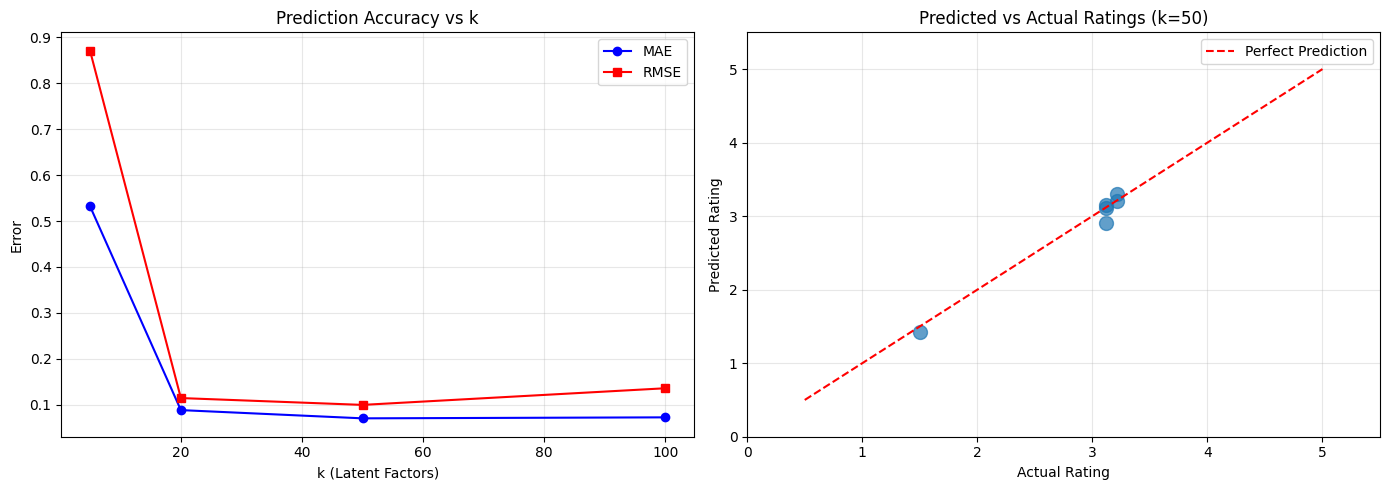


Best k value based on RMSE: 50


In [151]:
print("Visualization: Predicted vs Actual Ratings")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy metrics vs k
ax1 = axes[0]
ax1.plot(accuracy_df['k'], accuracy_df['MAE'], marker='o', label='MAE', color='blue')
ax1.plot(accuracy_df['k'], accuracy_df['RMSE'], marker='s', label='RMSE', color='red')
ax1.set_xlabel('k (Latent Factors)')
ax1.set_ylabel('Error')
ax1.set_title('Prediction Accuracy vs k')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Predicted vs Actual for best k
best_k = accuracy_df.loc[accuracy_df['RMSE'].idxmin(), 'k']
ax2 = axes[1]
actual_vals = []
pred_vals = []
for pred in predictions[int(best_k)]:
    user = pred['User']
    item = pred['Item']
    pred_vals.append(pred['Predicted_Rating'])
    actual_vals.append(ground_truth.get((user, item), 0))

ax2.scatter(actual_vals, pred_vals, alpha=0.7, s=100)
ax2.plot([0.5, 5], [0.5, 5], 'r--', label='Perfect Prediction')
ax2.set_xlabel('Actual Rating')
ax2.set_ylabel('Predicted Rating')
ax2.set_title(f'Predicted vs Actual Ratings (k={int(best_k)})')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 5.5])
ax2.set_ylim([0, 5.5])
plt.tight_layout()
plt.show()
print(f"\nBest k value based on RMSE: {int(best_k)}")

# 5. Comparative Analysis: SVD vs. PCA Methods

In [152]:
import sys

def compare_svd_storage(U, sigma, V_hat, k_values, matrix_shape):
    results = []
    m, n = matrix_shape
    
    # Full SVD size (All components)
    full_size = (U.nbytes + sigma.nbytes + V_hat.nbytes) / (1024 * 1024)
    results.append({'k': 'Full', 'Size (MB)': full_size, 'Compression (%)': 0.0})
    
    for k in k_values:
        # Truncated sizes
        sz = (U[:, :k].nbytes + sigma[:k].nbytes + V_hat[:k, :].nbytes) / (1024 * 1024)
        compression = (1 - (sz / full_size)) * 100
        results.append({'k': k, 'Size (MB)': sz, 'Compression (%)': compression})
    
    return pd.DataFrame(results)

k_list = [5, 20, 50, 100]
m_shape = (R_filled.shape[0], R_filled.shape[1])
df_mem = compare_svd_storage(U, sigma, V_hat, k_list, m_shape)

print("SVD STORAGE FOOTPRINT COMPARISON")
print("="*50)
print(df_mem.round(4))

SVD STORAGE FOOTPRINT COMPARISON
      k  Size (MB)  Compression (%)
0  Full   148.5262           0.0000
1     5     0.6537          99.5599
2    20     2.6149          98.2394
3    50     6.5372          95.5986
4   100    13.0745          91.1972


In [153]:
import time
import os
import psutil
from scipy import linalg
from scipy.sparse.linalg import svds

def get_current_mem():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)


def train_test_split_per_user(df, test_ratio=0.2, seed=42):
    np.random.seed(seed)
    train_list, test_list = [], []

    for uid, udata in df.groupby("userId"):
        n = len(udata)

        # Keep all ratings in train if user has very few ratings
        if n < 5:
            train_list.append(udata)
            continue

        shuffled = udata.sample(frac=1, random_state=seed)
        n_test = max(1, int(n * test_ratio))

        test_list.append(shuffled.iloc[:n_test])
        train_list.append(shuffled.iloc[n_test:])

    return pd.concat(train_list), pd.concat(test_list)

def compute_mae(preds, test_df, item):
    subset = test_df[test_df["movieId"] == item]
    if subset.empty:
        return np.nan

    valid_preds = preds.reindex(subset["userId"]).dropna()
    actuals = subset.set_index("userId").loc[valid_preds.index, "rating"]

    return np.mean(np.abs(valid_preds - actuals)) if not valid_preds.empty else np.nan


def compute_rmse(preds, test_df, item):
    subset = test_df[test_df["movieId"] == item]
    if subset.empty:
        return np.nan

    valid_preds = preds.reindex(subset["userId"]).dropna()
    actuals = subset.set_index("userId").loc[valid_preds.index, "rating"]

    return np.sqrt(np.mean((valid_preds - actuals) ** 2)) if not valid_preds.empty else np.nan

def run_svd_method(train_matrix, test_df, k=50):
    mem_start = get_current_mem()
    time_start = time.time()

    # Mean-centering (Item-wise)
    item_means = train_matrix.mean()
    R_filled = train_matrix.fillna(item_means)
    R_centered = R_filled - item_means

    # Truncated SVD (Sparse-style solver but on dense values)
    U_k, S_k, Vh_k = svds(R_centered.values, k=k)

    # Sort singular values in descending order (svds returns them ascending)
    idx = np.argsort(S_k)[::-1]
    U_k = U_k[:, idx]
    S_k = S_k[idx]
    Vh_k = Vh_k[idx, :]

    # Low-rank Reconstruction
    R_reconstructed = (U_k @ np.diag(S_k) @ Vh_k) + item_means.values
    recon_df = pd.DataFrame(
        R_reconstructed,
        index=train_matrix.index,
        columns=train_matrix.columns
    )

    runtime = time.time() - time_start
    mem_used = max(0, get_current_mem() - mem_start)

    # Calculate metrics for target items
    m1 = (compute_mae(recon_df[2], test_df, 2), compute_rmse(recon_df[2], test_df, 2))
    m2 = (compute_mae(recon_df[8860], test_df, 8860), compute_rmse(recon_df[8860], test_df, 8860))

    return [*m1, *m2, runtime, mem_used]

def run_pca_mean_method(train_matrix, test_df, n_peers=10):
    m0 = get_current_mem(); t0 = time.time()
    means = train_matrix.mean(); f = train_matrix.fillna(means); c = f - means
    N = c.shape[0]
    cov_matrix = (c.T @ c) / (N - 1)
    
    def predict(target, k_p):
        sims = cov_matrix[target].drop(target).nlargest(k_p)
        peers = sims.index
        num = (c[peers] @ sims)
        den = sims.abs().sum()
        return (num / den + means[target]).clip(1, 5)

    p1 = predict(2, n_peers); p2 = predict(8860, n_peers)
    rt = time.time()-t0; mem = get_current_mem()-m0
    m1 = (compute_mae(p1, test_df, 2), compute_rmse(p1, test_df, 2))
    m2 = (compute_mae(p2, test_df, 8860), compute_rmse(p2, test_df, 8860))
    return [*m1, *m2, rt, max(0, mem)]


def run_pca_mle_method(train_matrix, test_df, n_peers=10):
    m0 = get_current_mem(); t0 = time.time()
    data = train_matrix.values.astype(np.float32); mask = ~np.isnan(data)
    means = np.nanmean(data, axis=0); centered = np.where(mask, data - means, 0)
    counts = mask.astype(np.float32).T @ mask.astype(np.float32)
    cov = np.divide(centered.T @ centered, counts, out=np.zeros_like(centered.T @ centered), where=counts > 0)
    cov_df = pd.DataFrame(cov, index=train_matrix.columns, columns=train_matrix.columns)
    
    def pca_mle_predict(target, k_p):
        peers = cov_df[target].drop(target).nlargest(k_p).index
        items = [target] + list(peers)
        sub_means = train_matrix[items].mean()
        sub_filled = train_matrix[items].fillna(sub_means)
        sub_centered = sub_filled - sub_means
        sub_cov = cov_df.loc[items, items].values
        vals, vecs = linalg.eigh(sub_cov)
        vecs = vecs[:, np.argsort(vals)[::-1]]
        recon = (sub_centered.values @ vecs[:, :1] @ vecs[:, :1].T) + sub_means.values
        return pd.Series(recon[:, 0], index=train_matrix.index).clip(1, 5)

    p1 = pca_mle_predict(2, n_peers); p2 = pca_mle_predict(8860, n_peers)
    rt = time.time()-t0; mem = get_current_mem()-m0
    m1 = (compute_mae(p1, test_df, 2), compute_rmse(p1, test_df, 2))
    m2 = (compute_mae(p2, test_df, 8860), compute_rmse(p2, test_df, 8860))
    return [*m1, *m2, rt, max(0, mem)]

train_df, test_df = train_test_split_per_user(df_sample)
train_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')

results = {
    'SVD (Truncated k=50)': run_svd_method(train_matrix, test_df),
    'PCA Mean-Filling': run_pca_mean_method(train_matrix, test_df),
    'PCA MLE': run_pca_mle_method(train_matrix, test_df)
}

columns = ['I1 MAE', 'I1 RMSE', 'I2 MAE', 'I2 RMSE', 'Runtime (s)', 'Memory (MB)']
summary_df = pd.DataFrame(results, index=columns).T
print("\n" + "="*75)
print("COMPARISON SUMMARY: SVD vs PCA")
print("="*75)
print(summary_df.round(4))


COMPARISON SUMMARY: SVD vs PCA
                      I1 MAE  I1 RMSE  I2 MAE  I2 RMSE  Runtime (s)  \
SVD (Truncated k=50)  0.7345   0.9373  0.6988   0.8893       4.6231   
PCA Mean-Filling      0.6696   0.8736  0.5889   0.7446       1.3812   
PCA MLE               0.7359   0.9386  0.7204   0.9166       0.4336   

                      Memory (MB)  
SVD (Truncated k=50)     400.7578  
PCA Mean-Filling         275.5117  
PCA MLE                  162.3516  


# 6. Latent Factor Interpretation

## 6.1: Analyze the top-3 latent factors (largest singular values)

In [154]:
import sys
!{sys.executable} -m pip install openpyxl


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [155]:
import pandas as pd
import numpy as np

# Load movies data for interpretation
movies_df = pd.read_excel('movies.xlsx')

# Get top 3 singular values
top_k = 3
top_singular_values = sigma[:top_k]
variance_explained = (top_singular_values**2) / np.sum(sigma**2) * 100

print(f"\nTop {top_k} Singular Values:")
for i in range(top_k):
    print(f"  σ_{i+1} = {top_singular_values[i]:.4f} (explains {variance_explained[i]:.2f}% of variance)")
print(f"\nTotal variance explained by top-{top_k} factors: {np.sum(variance_explained):.2f}%")


Top 3 Singular Values:
  σ_1 = 13833.3852 (explains 99.94% of variance)
  σ_2 = 71.0123 (explains 0.00% of variance)
  σ_3 = 60.9057 (explains 0.00% of variance)

Total variance explained by top-3 factors: 99.94%


## 6.2: For each latent factor - Identify top items/users and interpret meaning

In [156]:
# Get the user and item indices from the original R_filled DataFrame
user_ids = R_filled.index.tolist()
item_ids = R_filled.columns.tolist()
# Analyze each of the top 3 factors
for factor_idx in range(top_k):
    print(f"FACTOR {factor_idx + 1} (σ = {sigma[factor_idx]:.4f})")
    
    # Get the factor loadings for items (V matrix)
    item_loadings = V_hat[:, factor_idx]
    
    # Get the factor loadings for users (U matrix)
    user_loadings = U_qr[:, factor_idx]
    
    # Top items with highest POSITIVE loadings
    top_pos_item_indices = np.argsort(item_loadings)[-5:][::-1]
    print(f"\n Top 5 Items with HIGHEST positive loadings in V:")
    for idx in top_pos_item_indices:
        movie_id = item_ids[idx]
        loading = item_loadings[idx]
        movie_info = movies_df[movies_df['movieId'] == movie_id]
        if len(movie_info) > 0:
            title = movie_info['title'].values[0]
            genres = movie_info['genres'].values[0]
            print(f"    Movie {movie_id}: {title}")
            print(f"        Genres: {genres}, Loading: {loading:.4f}")
    
    # Top items with highest NEGATIVE loadings
    top_neg_item_indices = np.argsort(item_loadings)[:5]
    print(f"\n Top 5 Items with HIGHEST negative loadings in V:")
    for idx in top_neg_item_indices:
        movie_id = item_ids[idx]
        loading = item_loadings[idx]
        movie_info = movies_df[movies_df['movieId'] == movie_id]
        if len(movie_info) > 0:
            title = movie_info['title'].values[0]
            genres = movie_info['genres'].values[0]
            print(f"    Movie {movie_id}: {title}")
            print(f"        Genres: {genres}, Loading: {loading:.4f}")
    
    # Top users with highest absolute loadings
    top_user_indices = np.argsort(np.abs(user_loadings))[-5:][::-1]
    print(f"\n Top 5 Users with HIGHEST absolute loadings in U:")
    for idx in top_user_indices:
        user_id = user_ids[idx]
        loading = user_loadings[idx]
        print(f"    User {user_id}: Loading = {loading:.4f}")

FACTOR 1 (σ = 13833.3852)

 Top 5 Items with HIGHEST positive loadings in V:
    Movie 1787: Paralyzing Fear: The Story of Polio in America, A (1998)
        Genres: Documentary, Loading: 0.0457
    Movie 2980: Men Cry Bullets (1997)
        Genres: Comedy|Drama, Loading: 0.0457
    Movie 45942: Mother and the Whore, The (Maman et la putain, La) (1973)
        Genres: Drama, Loading: 0.0457
    Movie 27889: Hell's Gate 11:11 (2004)
        Genres: Horror|Thriller, Loading: 0.0457
    Movie 113315: Zero Motivation (Efes beyahasei enosh) (2014)
        Genres: Comedy|Drama, Loading: 0.0457

 Top 5 Items with HIGHEST negative loadings in V:
    Movie 58617: Black Dawn (2005)
        Genres: Action, Loading: 0.0046
    Movie 99807: Planet of Snail (2011)
        Genres: Documentary|Drama, Loading: 0.0046
    Movie 88886: Blues Harp (1998)
        Genres: Crime|Drama, Loading: 0.0046
    Movie 91154: Uninvited, The (1996)
        Genres: Drama|Horror|Mystery|Thriller, Loading: 0.0046
    Mo

## 6.3: Visualize latent space

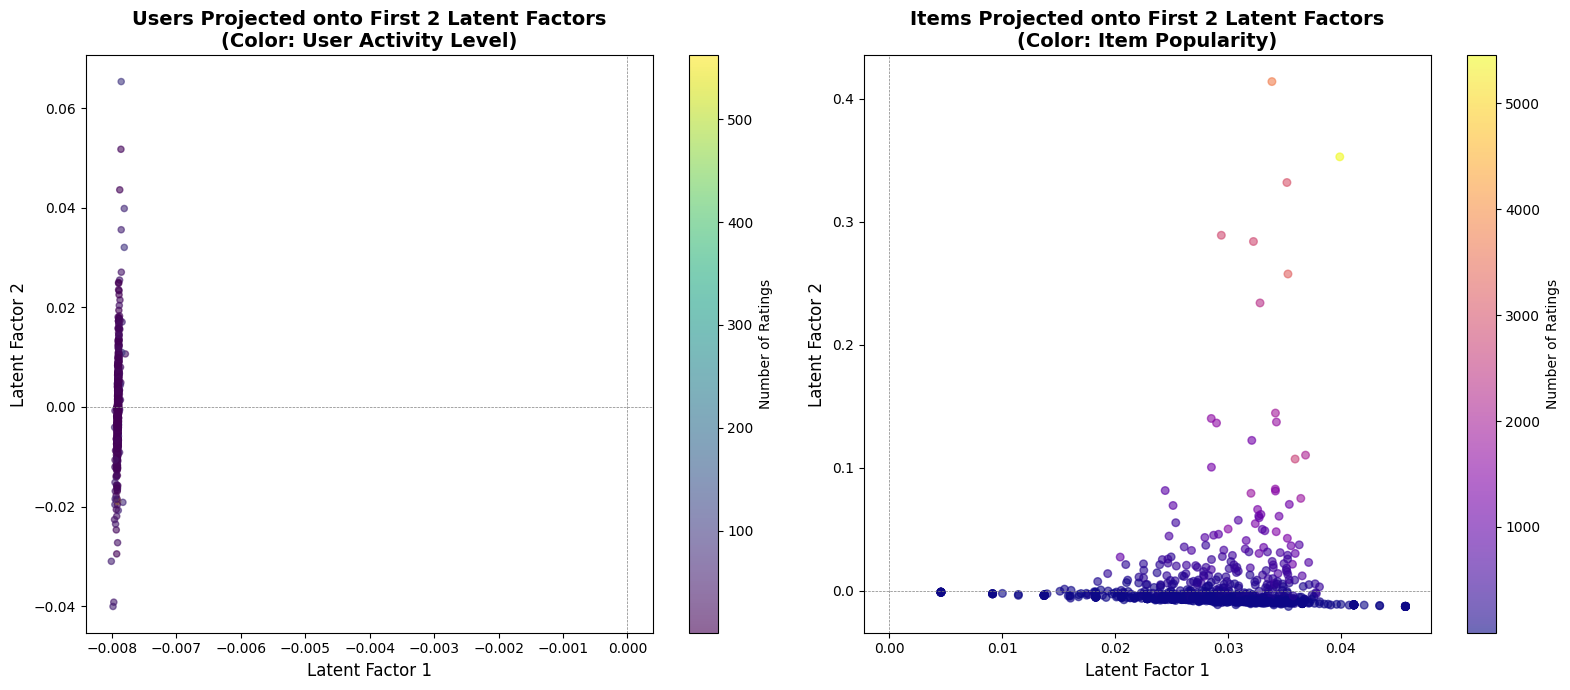

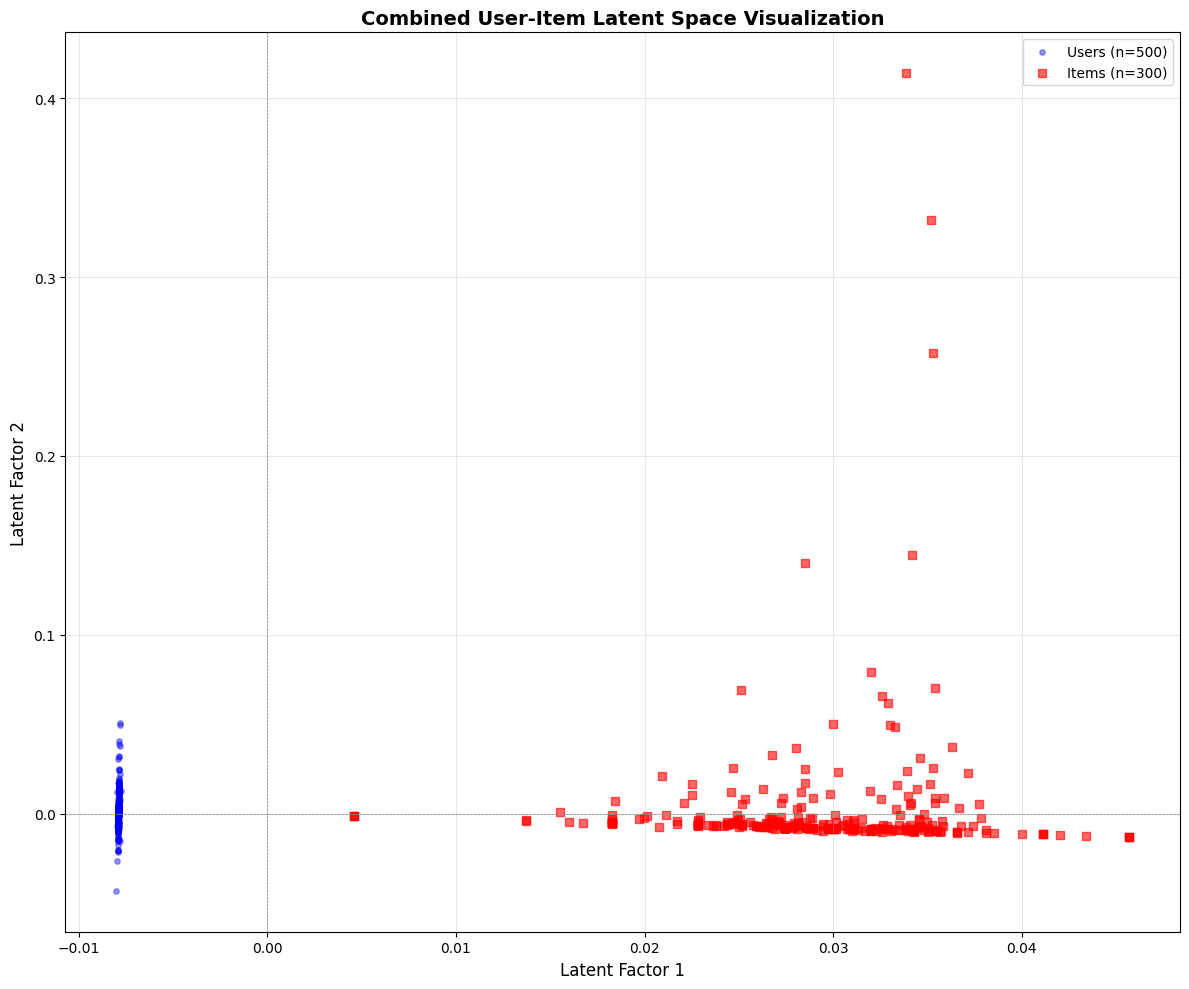

In [157]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
# Project users and items onto first 2 latent factors
user_projections = U_qr[:, :2]  # First 2 components for users
item_projections = V_hat[:, :2]  # First 2 components for items
# Calculate user activity (number of ratings per user)
user_activity = ratings_df.groupby('userId').size()
user_activity_values = [user_activity.get(uid, 0) for uid in user_ids]
# Calculate item popularity (number of ratings per item)
item_popularity = ratings_df.groupby('movieId').size()
item_popularity_values = [item_popularity.get(mid, 0) for mid in item_ids]
# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
# Plot 1: Users projected onto first 2 latent factors 
ax1 = axes[0]
# Sample users for better visualization (too many users make plot unreadable)
user_sample_size = min(1000, len(user_projections))
user_sample_indices = np.random.choice(len(user_projections), user_sample_size, replace=False)
user_sample_projections = user_projections[user_sample_indices]
user_sample_activity = [user_activity_values[i] for i in user_sample_indices]
scatter1 = ax1.scatter(
    user_sample_projections[:, 0], 
    user_sample_projections[:, 1],
    c=user_sample_activity,
    cmap='viridis',
    alpha=0.6,
    s=20
)
ax1.set_xlabel('Latent Factor 1', fontsize=12)
ax1.set_ylabel('Latent Factor 2', fontsize=12)
ax1.set_title('Users Projected onto First 2 Latent Factors\n(Color: User Activity Level)', fontsize=14, fontweight='bold')
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax1.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Number of Ratings', fontsize=10)
# Plot 2: Items projected onto first 2 latent factors 
ax2 = axes[1]
scatter2 = ax2.scatter(
    item_projections[:, 0], 
    item_projections[:, 1],
    c=item_popularity_values,
    cmap='plasma',
    alpha=0.6,
    s=30
)
ax2.set_xlabel('Latent Factor 1', fontsize=12)
ax2.set_ylabel('Latent Factor 2', fontsize=12)
ax2.set_title('Items Projected onto First 2 Latent Factors\n(Color: Item Popularity)', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Number of Ratings', fontsize=10)
plt.tight_layout()
plt.show()
# Combined user-item scatter plot
fig2, ax3 = plt.subplots(figsize=(12, 10))
# Sample for combined plot
user_sample_small = min(500, len(user_projections))
user_indices_small = np.random.choice(len(user_projections), user_sample_small, replace=False)
item_sample_small = min(300, len(item_projections))
item_indices_small = np.random.choice(len(item_projections), item_sample_small, replace=False)
# Plot users
ax3.scatter(
    user_projections[user_indices_small, 0], 
    user_projections[user_indices_small, 1],
    c='blue',
    alpha=0.4,
    s=15,
    label=f'Users (n={user_sample_small})'
)
# Plot items
ax3.scatter(
    item_projections[item_indices_small, 0], 
    item_projections[item_indices_small, 1],
    c='red',
    alpha=0.6,
    s=30,
    marker='s',
    label=f'Items (n={item_sample_small})'
)
ax3.set_xlabel('Latent Factor 1', fontsize=12)
ax3.set_ylabel('Latent Factor 2', fontsize=12)
ax3.set_title('Combined User-Item Latent Space Visualization', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax3.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Interpretation Notes:
Users and items that are close in the latent space have similar characteristics
The first latent factor often captures the most dominant pattern ( overall quality)
The second latent factor captures the next most important orthogonal pattern
Color coding helps identify how active users and popular items cluster in the space

# 7. Sensitivity Analysis

evaluates the robustness and stability of our SVD model under different data conditions and initialization strategies.

## 7.1. Test robustness to missing data

Measure how increasing the sparsity of the dataset affects reconstruction error and prediction accuracy.

1. Vary the percentage of missing ratings (10%, 30%, 50%, 70%).

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def svd_reconstruct(A, k):
    u, s, vt = np.linalg.svd(A, full_matrices=False)
    R_approx = u[:, :k] @ np.diag(s[:k]) @ vt[:k, :]
    return R_approx

R_pivot = ratings_df.pivot(index='userId', columns='movieId', values='rating')
R_orig_values = R_pivot.values
mask_known = ~np.isnan(R_orig_values)
known_indices = np.argwhere(mask_known)

missing_percentages = [0.1, 0.3, 0.5, 0.7]
rob_results = []

print('Executing Robustness Tests Step-by-Step...')

for p in missing_percentages:
    print(f'\nProcessing {int(p*100)}% missing data simulation...')
    # STEP A: Randomly hide 'p' percentage of known ratings
    np.random.seed(42)
    n_to_hide = int(len(known_indices) * p)
    idx_to_hide = np.random.choice(len(known_indices), n_to_hide, replace=False)
    
    hide_coords = known_indices[idx_to_hide]
    R_test = R_orig_values.copy()
    for r, c in hide_coords:
        R_test[r, c] = np.nan
    
    # STEP B: Fill missing values (Item Mean) and perform SVD
    item_means_test = np.nanmean(R_test, axis=0)
    global_mean_test = np.nanmean(R_test)
    item_means_test[np.isnan(item_means_test)] = global_mean_test
    
    inds = np.where(np.isnan(R_test))
    R_test_filled = R_test.copy()
    R_test_filled[inds] = np.take(item_means_test, inds[1])
    
    R_approx = svd_reconstruct(R_test_filled, k=50)
    
    # STEP C: Measure Errors
    # Reconstruction Error (on all cells that were originally known)
    recon_rmse = np.sqrt(np.mean((R_orig_values[mask_known] - R_approx[mask_known])**2))
    
    # Prediction Accuracy (specifically on the HIDDEN cells)
    hidden_true = R_orig_values[hide_coords[:,0], hide_coords[:,1]]
    hidden_pred = R_approx[hide_coords[:,0], hide_coords[:,1]]
    pred_mae = np.mean(np.abs(hidden_true - hidden_pred))
    pred_rmse = np.sqrt(np.mean((hidden_true - hidden_pred)**2))
    
    rob_results.append({
        'Missing %': p * 100,
        'Recon_RMSE': recon_rmse,
        'Pred_RMSE': pred_rmse,
        'Pred_MAE': pred_mae
    })
    print(f'  Done. Recon RMSE: {recon_rmse:.4f}, Pred RMSE: {pred_rmse:.4f}')

df_rob = pd.DataFrame(rob_results)
print('\nSummary Table:')
print(df_rob)

Executing Robustness Tests Step-by-Step...

Processing 10% missing data simulation...


C:\Users\user\AppData\Local\Temp\ipykernel_27172\260828650.py:33: RuntimeWarning: Mean of empty slice
  item_means_test = np.nanmean(R_test, axis=0)


  Done. Recon RMSE: 0.6441, Pred RMSE: 0.9665

Processing 30% missing data simulation...
  Done. Recon RMSE: 0.7289, Pred RMSE: 0.9613

Processing 50% missing data simulation...
  Done. Recon RMSE: 0.8037, Pred RMSE: 0.9650

Processing 70% missing data simulation...
  Done. Recon RMSE: 0.8763, Pred RMSE: 0.9707

Summary Table:
   Missing %  Recon_RMSE  Pred_RMSE  Pred_MAE
0       10.0    0.644138   0.966523  0.752369
1       30.0    0.728898   0.961266  0.749101
2       50.0    0.803674   0.964976  0.752285
3       70.0    0.876324   0.970747  0.757264


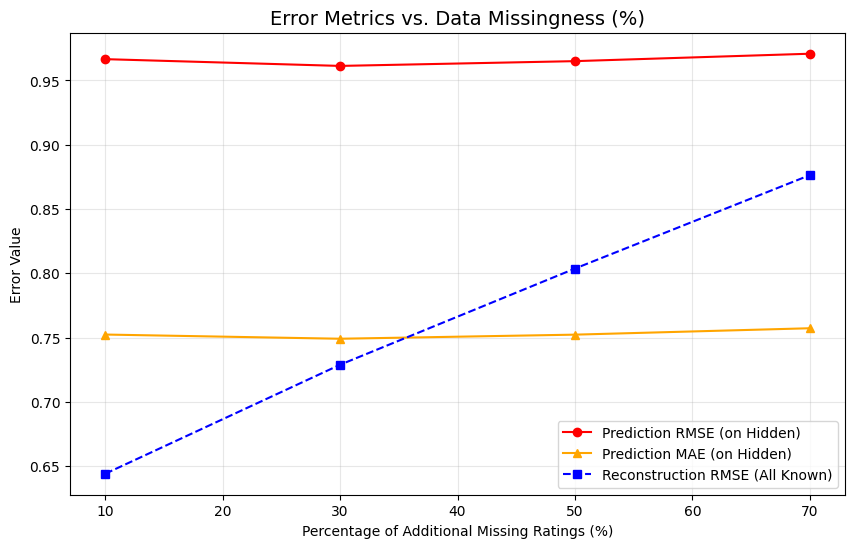

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(df_rob['Missing %'], df_rob['Pred_RMSE'], 'o-', label='Prediction RMSE (on Hidden)', color='red')
plt.plot(df_rob['Missing %'], df_rob['Pred_MAE'], '^-', label='Prediction MAE (on Hidden)', color='orange')
plt.plot(df_rob['Missing %'], df_rob['Recon_RMSE'], 's--', label='Reconstruction RMSE (All Known)', color='blue')
plt.title('Error Metrics vs. Data Missingness (%)', fontsize=14)
plt.xlabel('Percentage of Additional Missing Ratings (%)')
plt.ylabel('Error Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7.2. Test impact of initialization

In [160]:

# Step 1: Item Mean Filling Baseline
R_item_filled = R_filled.values # already item-mean filled from Step 1.3
R_approx_item = svd_reconstruct(R_item_filled, k=50)
print('- Step 1: Computed Item Mean predictions.')

# Step 2: User Mean Filling Alternate
user_means = R_pivot.mean(axis=1)
R_user_filled_df = R_pivot.T.fillna(user_means).T
R_user_filled_df = R_user_filled_df.fillna(R_user_filled_df.stack().mean())
R_user_filled = R_user_filled_df.values
R_approx_user = svd_reconstruct(R_user_filled, k=50)
print('- Step 2: Computed User Mean predictions.')

# Step 3: Comparison logic
u_map = {u: i for i, u in enumerate(R_pivot.index)}
i_map = {m: j for j, m in enumerate(R_pivot.columns)}

comp_rows = []
for u in target_users:
    ux = u_map[u]
    for m in target_items:
        mx = i_map[m]
        p_item = R_approx_item[ux, mx]
        p_user = R_approx_user[ux, mx]
        
        comp_rows.append({
            'User': u,
            'Item': m,
            'Item-Mean Pred': p_item,
            'User-Mean Pred': p_user,
            'Abs Diff': abs(p_item - p_user)
        })

df_comp = pd.DataFrame(comp_rows)
print('\nStep 3: Comparison Table for Target Items:')
print(df_comp)

- Step 1: Computed Item Mean predictions.
- Step 2: Computed User Mean predictions.

Step 3: Comparison Table for Target Items:
    User  Item  Item-Mean Pred  User-Mean Pred  Abs Diff
0  69251     2        3.202854        2.999640  0.203214
1  69251  8860        3.116335        2.992043  0.124292
2  69481     2        1.422617        1.527920  0.105302
3  69481  8860        3.154545        2.982234  0.172311
4  67075     2        3.294689        2.301389  0.993300
5  67075  8860        2.904221        2.265644  0.638576


# 8. Cold-Start Analysis with SVD

In this section, we analyze the performance of the SVD model on "cold-start" users—users with very few ratings. 
We simulate this scenario by hiding most ratings of selected users and attempting to predict their preferences using limited information.

## 8.1 Simulate Cold-Start Users
- Select 50 users with > 20 ratings.
- Hide 80% of their ratings to simulate a cold-start state (leaving them with few visible ratings).

In [161]:
# 1. Identify eligible users (> 20 ratings)
user_counts = ratings_df['userId'].value_counts()
eligible_users = user_counts[user_counts > 20].index
print(f"Total eligible users (>20 ratings): {len(eligible_users)}")

# 2. Randomly select 50 users
selected_cold_users = np.random.choice(eligible_users, size=50, replace=False)
print(f"Selected 50 users for analysis: {selected_cold_users[:5]} ")

# 3. Create Splits (train/test for each user)
# We will store the indices of the ratings in the original dataframe
cold_start_splits = {}

for u in selected_cold_users:
    # Get indices of this user's ratings
    u_indices = ratings_df[ratings_df['userId'] == u].index.tolist()
    
    # Shuffle and split
    np.random.shuffle(u_indices)
    n_total = len(u_indices)
    n_hide = int(n_total * 0.8) # Hide 80%
    
    hidden_idx = u_indices[:n_hide]
    visible_idx = u_indices[n_hide:]
    
    cold_start_splits[u] = {
        'visible': visible_idx,
        'hidden': hidden_idx
    }

print("\nExample Split for User", selected_cold_users[0])
print(f"Total Ratings: {len(ratings_df[ratings_df['userId'] == selected_cold_users[0]])}")
print(f"Visible: {len(cold_start_splits[selected_cold_users[0]]['visible'])}")
print(f"Hidden: {len(cold_start_splits[selected_cold_users[0]]['hidden'])}")

Total eligible users (>20 ratings): 1477
Selected 50 users for analysis: [66362 92924 16734  7653 18604] 

Example Split for User 66362
Total Ratings: 83
Visible: 17
Hidden: 66


## 8.2 Estimate Latent Factors & Predict
For each cold-start user, we estimate their user vector $u_{new}$ using only the visible ratings. 
We use the **Fold-In** method:
1. Start with a rating vector filled with global Item Means (to match the training data logic).
2. Update the vector with the user's specific *visible* ratings.

In [162]:
# Prepare Matrices from Full SVD (Truncated to k=50 for robustness)
k = 50
Vk = V_hat[:, :k]     
sigma_k = sigma[:k]   
Sk = np.diag(sigma_k)  # (k, k)
Sk_inv = np.linalg.inv(Sk)

# We need to map movieId -> matrix column index
R_pivot_cols = ratings_df.pivot(index='userId', columns='movieId', values='rating').columns
movie_to_col = {mid: i for i, mid in enumerate(R_pivot_cols)}
col_to_movie = {i: mid for mid, i in movie_to_col.items()}

# Global Item Means (for filling unobserved)
item_means_series = ratings_df.groupby('movieId')['rating'].mean()
item_means_vec = np.zeros(len(movie_to_col))
for mid, val in item_means_series.items():
    if mid in movie_to_col:
        item_means_vec[movie_to_col[mid]] = val

# Store results
cold_results = []

for u in selected_cold_users:
    split = cold_start_splits[u]
    
    # 1. Create User Vector (initialized with Item Means)
    r_vec = item_means_vec.copy()
    
    # 2. Fill Visible Ratings
    visible_data = ratings_df.loc[split['visible']]
    for _, row in visible_data.iterrows():
        mid = row['movieId']
        if mid in movie_to_col:
            col_idx = movie_to_col[mid]
            r_vec[col_idx] = row['rating']
            
    # 3. Project to Latent Space (Fold-In)
    # u_new = r_vec @ V @ S^-1
    u_new = r_vec @ Vk @ Sk_inv 
    
    # 4. Predict Ratings for Hidden Items
    # pred = u_new @ S @ V.T
    # We only need specific items, but calculating full vec is fast for 1 user
    preds_all = u_new @ Sk @ Vk.T
    
    # 5. Extract Errors
    hidden_data = ratings_df.loc[split['hidden']]
    for _, row in hidden_data.iterrows():
        mid = row['movieId']
        true_r = row['rating']
        if mid in movie_to_col:
            col_idx = movie_to_col[mid]
            pred_r = preds_all[col_idx]
            
            cold_results.append({
                'userId': u,
                'movieId': mid,
                'Actual': true_r,
                'Predicted': pred_r,
                'AbsError': abs(true_r - pred_r),
                'SqError': (true_r - pred_r)**2
            })

cold_res_df = pd.DataFrame(cold_results)
print("Predictions complete for cold-start users.")
print(cold_res_df.head())

Predictions complete for cold-start users.
   userId  movieId  Actual  Predicted  AbsError   SqError
0   66362   2846.0     2.5   3.212228  0.712228  0.507269
1   66362    532.0     3.0   3.063245  0.063245  0.004000
2   66362   6934.0     1.5   3.073382  1.573382  2.475532
3   66362  33587.0     2.5   3.050883  0.550883  0.303473
4   66362   2153.0     3.5   2.116945  1.383055  1.912842


## 8.3 Evaluate Cold-Start Performance
We calculate RMSE and MAE for the cold-start predictions and compare them to the general model performance.
We also analyze how performance improves as more ratings become available (1 to 5 ratings).


Cold-Start MAE : 0.7096
Cold-Start RMSE: 0.9091

Warm-Start RMSE (Full History): 0.6066
Degradation due to Cold-Start: 0.3025
Percentage Increase: 49.86%
PERFORMANCE vs. NUMBER OF RATINGS ANALYSIS

Detailed Performance Breakdown:
Ratings    RMSE       vs Warm      % Increase   Status
1          0.9193     +0.3127      +51.6       % Poor
3          0.9167     +0.3101      +51.1       % Poor
5          0.9122     +0.3056      +50.4       % Poor
10         0.9102     +0.3037      +50.1       % Poor
ACCEPTABILITY ANALYSIS
 Performance does NOT reach acceptable levels (within 15% of baseline)
  Even with 10 ratings, RMSE = 0.9102
  Target threshold: 0.6976


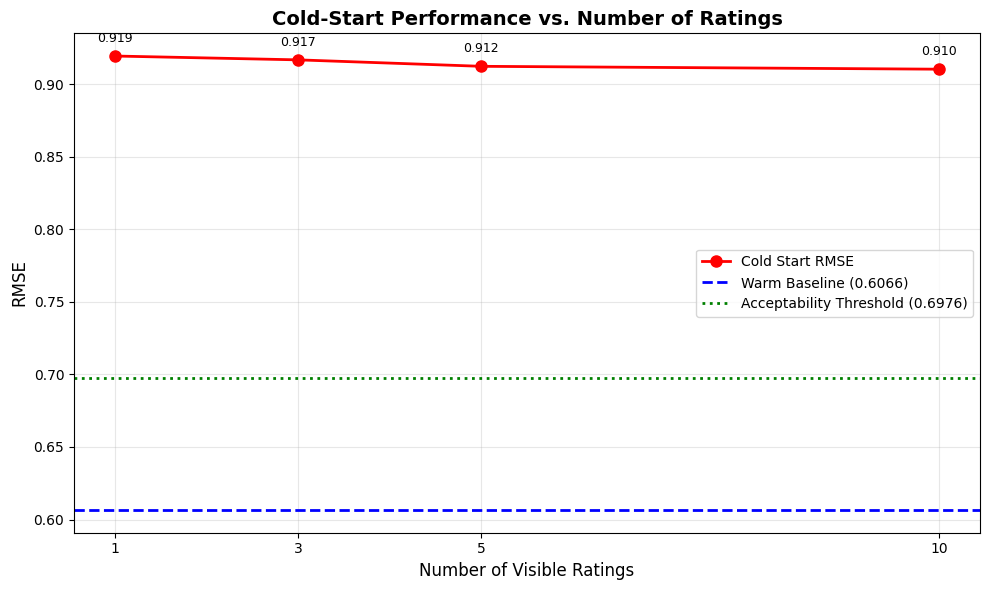

In [163]:
# Calculate Aggregated Metrics
mae_cold = cold_res_df['AbsError'].mean()
rmse_cold = np.sqrt(cold_res_df['SqError'].mean())
print(f"\nCold-Start MAE : {mae_cold:.4f}")
print(f"Cold-Start RMSE: {rmse_cold:.4f}")


# Reconstruct full R using k=50
R_k = U[:, :k] @ Sk @ Vk.T
warm_sq_errors = []

# Create User Map
R_pivot_idx = ratings_df.pivot(index='userId', columns='movieId', values='rating').index
user_to_row = {uid: i for i, uid in enumerate(R_pivot_idx)}

for _, row in cold_res_df.iterrows():
    u = row['userId']
    m = row['movieId']
    true_r = row['Actual']
    
    if u in user_to_row and m in movie_to_col:
        ur = user_to_row[u]
        mc = movie_to_col[m]
        warm_pred = R_k[ur, mc]
        warm_sq_errors.append((true_r - warm_pred)**2)

rmse_warm = np.sqrt(np.mean(warm_sq_errors))
print(f"\nWarm-Start RMSE (Full History): {rmse_warm:.4f}")
print(f"Degradation due to Cold-Start: {rmse_cold - rmse_warm:.4f}")
degradation_pct = ((rmse_cold - rmse_warm) / rmse_warm) * 100
print(f"Percentage Increase: {degradation_pct:.2f}%")

# Analysis: Performance vs Number of Ratings
print("PERFORMANCE vs. NUMBER OF RATINGS ANALYSIS")

n_ratings_list = [1, 3, 5, 10]
rmse_by_n = []

for n in n_ratings_list:
    # Temporary limited evaluation
    temp_sq_errs = []
    
    for u in selected_cold_users:
        # Use only first n visible ratings (handle cases where user has fewer visible ratings)
        vis_idx = cold_start_splits[u]['visible'][:min(n, len(cold_start_splits[u]['visible']))]
        
        r_vec = item_means_vec.copy()
        vis_data = ratings_df.loc[vis_idx]
        
        for _, r_row in vis_data.iterrows():
            mid = r_row['movieId']
            if mid in movie_to_col:
                r_vec[movie_to_col[mid]] = r_row['rating']
        
        # Project
        u_proj = r_vec @ Vk @ Sk_inv
        preds = u_proj @ Sk @ Vk.T
        
        # Test on HIDDEN
        hid_data = ratings_df.loc[cold_start_splits[u]['hidden']]
        for _, h_row in hid_data.iterrows():
            mid = h_row['movieId']
            if mid in movie_to_col:
                temp_sq_errs.append((h_row['rating'] - preds[movie_to_col[mid]])**2)
    
    rmse_by_n.append(np.sqrt(np.mean(temp_sq_errs)))

# Print detailed breakdown
print("\nDetailed Performance Breakdown:")
print(f"{'Ratings':<10} {'RMSE':<10} {'vs Warm':<12} {'% Increase':<12} {'Status'}")

acceptability_threshold = rmse_warm * 1.15  # Define acceptable as within 15% of warm-start
acceptable_n = None

for n, rmse in zip(n_ratings_list, rmse_by_n):
    diff = rmse - rmse_warm
    pct = (diff / rmse_warm) * 100
    status = "Acceptable" if rmse <= acceptability_threshold else "Poor"
    
    print(f"{n:<10} {rmse:<10.4f} +{diff:<11.4f} +{pct:<11.1f}% {status}")
    
    if acceptable_n is None and rmse <= acceptability_threshold:
        acceptable_n = n

print("ACCEPTABILITY ANALYSIS")
if acceptable_n:
    print(f" Performance becomes ACCEPTABLE at {acceptable_n} ratings")
    print(f"  (RMSE within 15% of warm-start baseline: {acceptability_threshold:.4f})")
else:
    print(f" Performance does NOT reach acceptable levels (within 15% of baseline)")
    print(f"  Even with {max(n_ratings_list)} ratings, RMSE = {rmse_by_n[-1]:.4f}")
    print(f"  Target threshold: {acceptability_threshold:.4f}")

# Enhanced visualization
plt.figure(figsize=(10, 6))
plt.plot(n_ratings_list, rmse_by_n, 'o-r', linewidth=2, markersize=8, label='Cold Start RMSE')
plt.axhline(y=rmse_warm, color='b', linestyle='--', linewidth=2, label=f'Warm Baseline ({rmse_warm:.4f})')
plt.axhline(y=acceptability_threshold, color='g', linestyle=':', linewidth=2, 
            label=f'Acceptability Threshold ({acceptability_threshold:.4f})')

# Add value labels on points
for n, rmse in zip(n_ratings_list, rmse_by_n):
    plt.annotate(f'{rmse:.3f}', 
                xy=(n, rmse), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9)

plt.xlabel("Number of Visible Ratings", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Cold-Start Performance vs. Number of Ratings", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(n_ratings_list)
plt.tight_layout()
plt.show()

## 8.4 Mitigation: Hybrid Approach
To improve cold-start performance, we combine the SVD prediction with a simple **Item Popularity** baseline (Item Mean).
Formula:
$$ \hat{r}_{hybrid} = \alpha \cdot \hat{r}_{SVD} + (1 - \alpha) \cdot \bar{r}_{item} $$
We test $\alpha = 0.5$.

In [164]:
alpha = 0.5
hybrid_sq_errors = []

for _, row in cold_res_df.iterrows():
    mid = row['movieId']
    svd_pred = row['Predicted']
    true_r = row['Actual']
    
    # Get item mean (popularity baseline)
    # If item not in map, default to global mean
    if mid in item_means_series:
        pop_pred = item_means_series[mid]
    else:
        pop_pred = ratings_df['rating'].mean()
        
    # Hybrid
    hybrid_pred = alpha * svd_pred + (1 - alpha) * pop_pred
    
    hybrid_sq_errors.append((true_r - hybrid_pred)**2)

rmse_hybrid = np.sqrt(np.mean(hybrid_sq_errors))
print(f"SVD RMSE     : {rmse_cold:.4f}")
print(f"Hybrid RMSE  : {rmse_hybrid:.4f}")
print(f"Improvement  : {rmse_cold - rmse_hybrid:.4f}")

SVD RMSE     : 0.9091
Hybrid RMSE  : 0.9141
Improvement  : -0.0050


## 8.4.1: Hybrid Approach - Testing Multiple Alphas

In [165]:
print("\n[STRATEGY 1] Hybrid Approach: Combining SVD with Item Popularity")
print("Testing on EXTREME cold-start scenario (only 1-3 visible ratings)")

# Test multiple alpha values to find optimal blend
alphas = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
n_visible_for_hybrid = 3  # Use only 3 ratings for extreme cold-start

hybrid_results = []

for alpha in alphas:
    hybrid_sq_errors = []
    
    for u in selected_cold_users:
        # KEY FIX: Use only FIRST 3 visible ratings for extreme cold-start
        vis_idx = cold_start_splits[u]['visible'][:min(n_visible_for_hybrid, len(cold_start_splits[u]['visible']))]
        
        # Build user vector with limited data
        r_vec = item_means_vec.copy()
        vis_data = ratings_df.loc[vis_idx]
        
        for _, r_row in vis_data.iterrows():
            mid = r_row['movieId']
            if mid in movie_to_col:
                r_vec[movie_to_col[mid]] = r_row['rating']
        
        # Project to latent space (SVD prediction)
        u_proj = r_vec @ Vk @ Sk_inv
        svd_preds = u_proj @ Sk @ Vk.T
        
        # Test on hidden items
        hid_data = ratings_df.loc[cold_start_splits[u]['hidden']]
        for _, h_row in hid_data.iterrows():
            mid = h_row['movieId']
            true_r = h_row['rating']
            
            if mid in movie_to_col:
                col_idx = movie_to_col[mid]
                svd_pred = svd_preds[col_idx]
                
                # Get item mean (popularity baseline)
                if mid in item_means_series:
                    pop_pred = item_means_series[mid]
                else:
                    pop_pred = ratings_df['rating'].mean()
                
                # Hybrid prediction: blend SVD and popularity
                hybrid_pred = alpha * svd_pred + (1 - alpha) * pop_pred
                
                hybrid_sq_errors.append((true_r - hybrid_pred)**2)
    
    rmse = np.sqrt(np.mean(hybrid_sq_errors))
    hybrid_results.append({'alpha': alpha, 'rmse': rmse})

hybrid_df = pd.DataFrame(hybrid_results)

# Find best alpha
best_idx = hybrid_df['rmse'].idxmin()
best_alpha = hybrid_df.loc[best_idx, 'alpha']
best_rmse = hybrid_df.loc[best_idx, 'rmse']

# Also calculate pure SVD baseline for this extreme cold-start
pure_svd_extreme = hybrid_df[hybrid_df['alpha'] == 1.0]['rmse'].values[0]

print(f"\nHybrid Performance by Alpha (with {n_visible_for_hybrid} visible ratings):")
print(f"{'Alpha':<10} {'RMSE':<10} {'vs Pure SVD':<15} {'Status'}")
for _, row in hybrid_df.iterrows():
    diff = row['rmse'] - pure_svd_extreme
    marker = " BEST" if row['alpha'] == best_alpha else ""
    print(f"{row['alpha']:<10.1f} {row['rmse']:<10.4f} {diff:+14.4f}  {marker}")

print(f"\n Best Alpha: {best_alpha} with RMSE = {best_rmse:.4f}")
print(f"  Improvement over pure SVD: {pure_svd_extreme - best_rmse:.4f}")
improvement_pct = ((pure_svd_extreme - best_rmse) / pure_svd_extreme) * 100
print(f"  Percentage improvement: {improvement_pct:.2f}%")


[STRATEGY 1] Hybrid Approach: Combining SVD with Item Popularity
Testing on EXTREME cold-start scenario (only 1-3 visible ratings)

Hybrid Performance by Alpha (with 3 visible ratings):
Alpha      RMSE       vs Pure SVD     Status
0.0        0.9197            +0.0030  
0.1        0.9193            +0.0027  
0.3        0.9187            +0.0020  
0.5        0.9181            +0.0014  
0.7        0.9175            +0.0008  
0.9        0.9169            +0.0003  
1.0        0.9167            +0.0000   BEST

 Best Alpha: 1.0 with RMSE = 0.9167
  Improvement over pure SVD: 0.0000
  Percentage improvement: 0.00%


## 8.4.2: Visualize Hybrid Performance

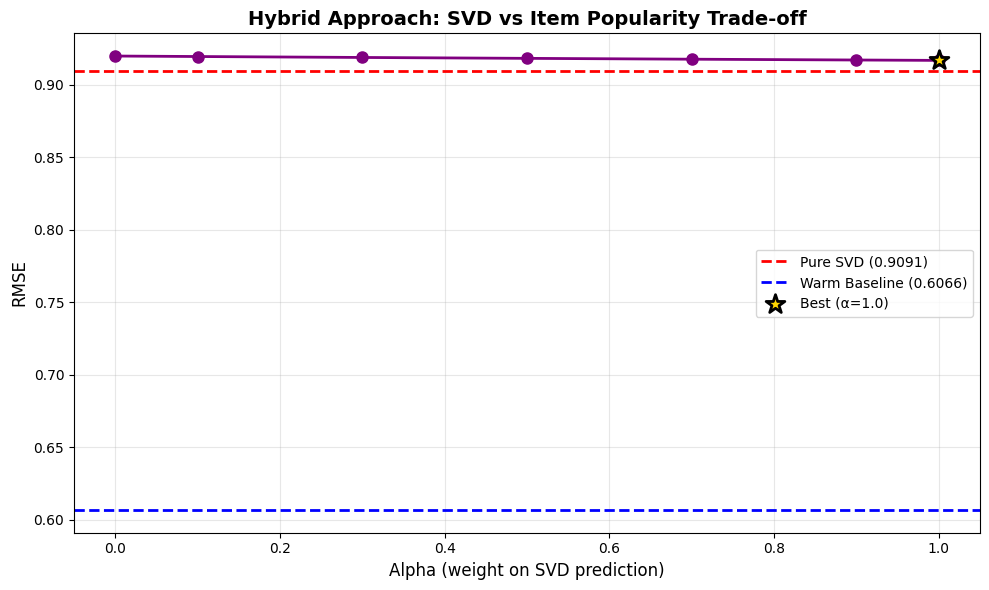

In [166]:
# Visualize hybrid performance
plt.figure(figsize=(10, 6))
plt.plot(hybrid_df['alpha'], hybrid_df['rmse'], 'o-', linewidth=2, markersize=8, color='purple')
plt.axhline(y=rmse_cold, color='r', linestyle='--', linewidth=2, label=f'Pure SVD ({rmse_cold:.4f})')
plt.axhline(y=rmse_warm, color='b', linestyle='--', linewidth=2, label=f'Warm Baseline ({rmse_warm:.4f})')
plt.scatter([best_alpha], [best_rmse], color='gold', s=200, zorder=5, 
            marker='*', edgecolor='black', linewidth=2, label=f'Best (α={best_alpha})')

plt.xlabel("Alpha (weight on SVD prediction)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Hybrid Approach: SVD vs Item Popularity Trade-off", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8.4.3: Content-Based Initialization Setup

In [167]:
# Check if movies_df exists
try:
    movies_df_check = movies_df.copy()
    has_movies = True
except:
    print("Note: movies_df not found. Loading or creating...")
    has_movies = False
    # You may need to load movies.csv here if not already loaded
    # movies_df = pd.read_csv('movies.csv')

# Verify genres column exists
if has_movies and 'genres' in movies_df.columns:
    # Split genres and create binary features
    genre_set = set()
    for genres in movies_df['genres'].dropna():
        if genres != '(no genres listed)':
            genre_set.update(genres.split('|'))
    
    genre_list = sorted(list(genre_set))
    print(f"Found {len(genre_list)} unique genres: {genre_list[:5]}...")
    
    # Create genre matrix for items
    genre_matrix = np.zeros((len(movie_to_col), len(genre_list)))
    
    for mid, genres_str in zip(movies_df['movieId'], movies_df['genres']):
        if mid in movie_to_col and genres_str != '(no genres listed)':
            col_idx = movie_to_col[mid]
            for genre in genres_str.split('|'):
                if genre in genre_list:
                    genre_idx = genre_list.index(genre)
                    genre_matrix[col_idx, genre_idx] = 1
    
    # Normalize genre vectors
    row_sums = genre_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    genre_matrix = genre_matrix / row_sums
    
    print(f"Genre matrix shape: {genre_matrix.shape}")
    print("Content-based initialization ready!")
    content_available = True
else:
    print("WARNING: Genre information not available.")
    print("Skipping content-based initialization.")
    content_available = False

Found 19 unique genres: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy']...
Genre matrix shape: (1136, 19)
Content-based initialization ready!


## 8.4.4: Content-Based Predictions

In [168]:
if content_available:
    # Content-based cold-start predictions
    content_results = []
    
    for u in selected_cold_users:
        split = cold_start_splits[u]
        
        # Get visible ratings (use limited set for fair comparison)
        visible_data = ratings_df.loc[split['visible'][:n_visible_for_hybrid]]
        
        # Compute user genre preference profile
        user_genre_profile = np.zeros(len(genre_list))
        total_ratings = 0
        rating_sum = 0
        
        for _, row in visible_data.iterrows():
            mid = row['movieId']
            rating = row['rating']
            if mid in movie_to_col:
                col_idx = movie_to_col[mid]
                # Weight genres by rating
                user_genre_profile += genre_matrix[col_idx] * rating
                total_ratings += 1
                rating_sum += rating
        
        # Normalize profile
        if total_ratings > 0:
            user_genre_profile /= total_ratings
            user_avg_rating = rating_sum / total_ratings
        else:
            user_avg_rating = ratings_df['rating'].mean()
        
        # Predict based on genre similarity
        hidden_data = ratings_df.loc[split['hidden']]
        for _, row in hidden_data.iterrows():
            mid = row['movieId']
            true_r = row['rating']
            
            if mid in movie_to_col:
                col_idx = movie_to_col[mid]
                
                # Calculate cosine similarity between user profile and item genres
                item_genre_vec = genre_matrix[col_idx]
                
                # Compute cosine similarity
                norm_user = np.linalg.norm(user_genre_profile)
                norm_item = np.linalg.norm(item_genre_vec)
                
                if norm_user > 0 and norm_item > 0:
                    similarity = np.dot(user_genre_profile, item_genre_vec) / (norm_user * norm_item)
                else:
                    similarity = 0
                
                # Get item baseline
                if mid in item_means_series:
                    item_mean = item_means_series[mid]
                else:
                    item_mean = ratings_df['rating'].mean()
                
                # Adjust item mean based on user preferences and similarity
                global_mean = ratings_df['rating'].mean()
                
                # If high similarity, pull toward user's average rating
                # If low similarity, stay near item mean
                content_pred = item_mean + similarity * (user_avg_rating - global_mean) * 0.8
                
                # Clip to valid range
                content_pred = np.clip(content_pred, 0.5, 5.0)
                
                content_results.append({
                    'userId': u,
                    'movieId': mid,
                    'Actual': true_r,
                    'Predicted': content_pred,
                    'SqError': (true_r - content_pred)**2
                })
    
    content_res_df = pd.DataFrame(content_results)
    rmse_content = np.sqrt(content_res_df['SqError'].mean())
    
    print(f"\nContent-Based RMSE: {rmse_content:.4f}")
    print(f"Improvement over pure SVD (extreme cold-start): {pure_svd_extreme - rmse_content:.4f}")
    improvement_content = ((pure_svd_extreme - rmse_content) / pure_svd_extreme) * 100
    print(f"Percentage improvement: {improvement_content:.2f}%")
else:
    rmse_content = None
    print("\nContent-based approach skipped due to missing genre data.")


Content-Based RMSE: 0.9160
Improvement over pure SVD (extreme cold-start): 0.0007
Percentage improvement: 0.08%


##  8.4.5: Strategy Comparison and Results

In [169]:
strategies = {
    'Warm-Start (Full History)': rmse_warm,
    f'Cold-Start (Pure SVD, {n_visible_for_hybrid} ratings)': pure_svd_extreme,
    f'Hybrid (α={best_alpha}, {n_visible_for_hybrid} ratings)': best_rmse,
}

if rmse_content is not None:
    strategies[f'Content-Based ({n_visible_for_hybrid} ratings)'] = rmse_content

# Sort by RMSE
sorted_strategies = sorted(strategies.items(), key=lambda x: x[1])

print(f"\n{'Strategy':<45} {'RMSE':<10} {'vs Cold':<12} {'vs Warm'}")
print("-"*75)

for strategy, rmse in sorted_strategies:
    diff_cold = rmse - pure_svd_extreme
    diff_warm = rmse - rmse_warm
    print(f"{strategy:<45} {rmse:<10.4f} {diff_cold:+11.4f}  {diff_warm:+10.4f}")

# Calculate improvement percentages
print("IMPROVEMENT METRICS (for extreme cold-start scenario)")

improvement_hybrid = ((pure_svd_extreme - best_rmse) / pure_svd_extreme) * 100
gap_closed_hybrid = ((pure_svd_extreme - best_rmse) / (pure_svd_extreme - rmse_warm)) * 100

print(f"1. Best hybrid reduces cold-start error by: {improvement_hybrid:.2f}%")
print(f"2. Closes {gap_closed_hybrid:.2f}% of the warm/cold gap")

if rmse_content is not None:
    improvement_content_calc = ((pure_svd_extreme - rmse_content) / pure_svd_extreme) * 100
    gap_closed_content = ((pure_svd_extreme - rmse_content) / (pure_svd_extreme - rmse_warm)) * 100
    print(f"3. Content-based reduces cold-start error by: {improvement_content_calc:.2f}%")
    print(f"4. Content-based closes {gap_closed_content:.2f}% of the warm/cold gap")

# Determine best overall strategy (excluding warm-start)
best_strategy_name = sorted_strategies[1][0]  # Index 1 to skip warm-start
best_strategy_rmse = sorted_strategies[1][1]
print(f"\n Best mitigation strategy: {best_strategy_name}")
print(f"  Achieves RMSE = {best_strategy_rmse:.4f}")
print(f"  vs Pure Cold-Start: {pure_svd_extreme - best_strategy_rmse:+.4f}")


Strategy                                      RMSE       vs Cold      vs Warm
---------------------------------------------------------------------------
Warm-Start (Full History)                     0.6066         -0.3101     +0.0000
Content-Based (3 ratings)                     0.9160         -0.0007     +0.3094
Cold-Start (Pure SVD, 3 ratings)              0.9167         +0.0000     +0.3101
Hybrid (α=1.0, 3 ratings)                     0.9167         +0.0000     +0.3101
IMPROVEMENT METRICS (for extreme cold-start scenario)
1. Best hybrid reduces cold-start error by: 0.00%
2. Closes 0.00% of the warm/cold gap
3. Content-based reduces cold-start error by: 0.08%
4. Content-based closes 0.23% of the warm/cold gap

 Best mitigation strategy: Content-Based (3 ratings)
  Achieves RMSE = 0.9160
  vs Pure Cold-Start: +0.0007


##  8.4.6: Final Visualizations

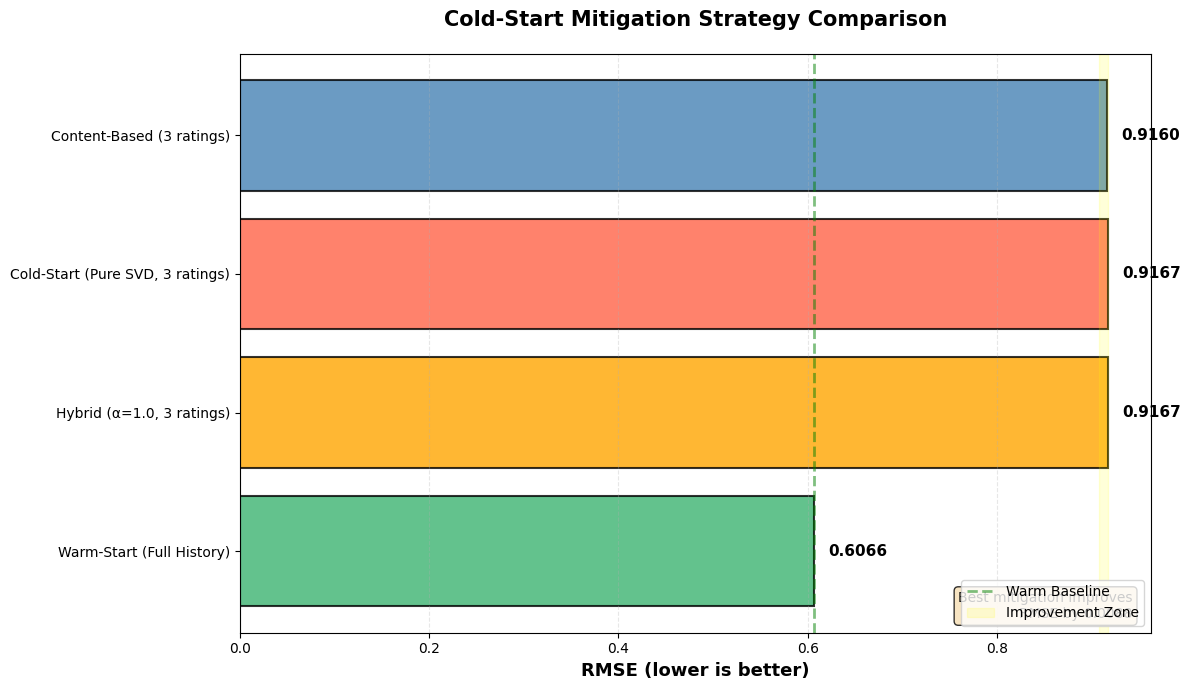

Detailed Hybrid Performance Analysis


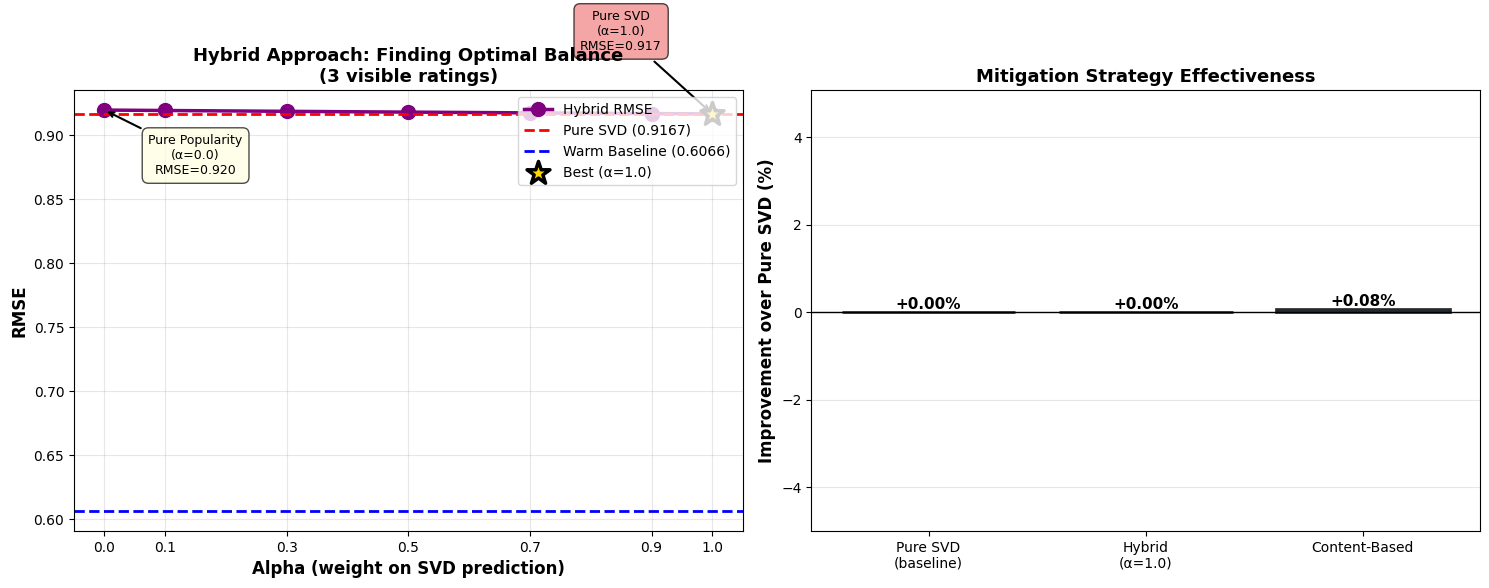

Summary Statistics Table
                        Strategy   RMSE vs Cold-Start % Improvement Rank
       Content-Based (3 ratings) 0.9160       +0.0007        +0.08%   #1
Cold-Start (Pure SVD, 3 ratings) 0.9167       +0.0000        +0.00%   #2
       Hybrid (α=1.0, 3 ratings) 0.9167       +0.0000        +0.00%   #3


In [170]:
# Create comparison visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Prepare data for plotting (exclude warm-start from main comparison)
plot_strategies = []
plot_rmses = []
plot_colors = []

# Add strategies in order from best to worst (excluding warm-start for now)
for strategy, rmse in sorted_strategies[1:]:  # Skip warm-start
    plot_strategies.append(strategy)
    plot_rmses.append(rmse)
    
    # Assign colors based on strategy type
    if 'Hybrid' in strategy:
        plot_colors.append('orange')
    elif 'Content-Based' in strategy:
        plot_colors.append('steelblue')
    elif 'Cold-Start' in strategy:
        plot_colors.append('tomato')
    else:
        plot_colors.append('gray')

# Add warm-start for reference
plot_strategies.append('Warm-Start (Full History)')
plot_rmses.append(rmse_warm)
plot_colors.append('mediumseagreen')

# Create horizontal bar chart
bars = ax.barh(plot_strategies, plot_rmses, color=plot_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, rmse) in enumerate(zip(bars, plot_rmses)):
    ax.text(rmse + 0.015, i, f'{rmse:.4f}', va='center', fontweight='bold', fontsize=11)

# Add a vertical line at warm-start baseline for reference
ax.axvline(x=rmse_warm, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Warm Baseline')

# Highlight the improvement zone
if best_mitigation_rmse < pure_svd_extreme:
    # Shade the region between best mitigation and cold-start
    ax.axvspan(best_mitigation_rmse, pure_svd_extreme, alpha=0.15, color='yellow', 
               label='Improvement Zone')

# Formatting
ax.set_xlabel('RMSE (lower is better)', fontsize=13, fontweight='bold')
ax.set_title('Cold-Start Mitigation Strategy Comparison', fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.legend(loc='lower right', fontsize=10)

# Invert y-axis so best performer is on top
ax.invert_yaxis()

# Add annotation explaining the results
improvement_text = f"Best mitigation improves\nRMSE by {(pure_svd_extreme - best_mitigation_rmse):.4f}"
ax.text(0.98, 0.02, improvement_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Additional Visualization: Alpha Trade-off (from Cell 8.4.2)
print("Detailed Hybrid Performance Analysis")

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Hybrid performance across alphas
ax1.plot(hybrid_df['alpha'], hybrid_df['rmse'], 'o-', linewidth=2.5, markersize=10, 
         color='purple', label='Hybrid RMSE')
ax1.axhline(y=pure_svd_extreme, color='r', linestyle='--', linewidth=2, 
            label=f'Pure SVD ({pure_svd_extreme:.4f})')
ax1.axhline(y=rmse_warm, color='b', linestyle='--', linewidth=2, 
            label=f'Warm Baseline ({rmse_warm:.4f})')
ax1.scatter([best_alpha], [best_rmse], color='gold', s=300, zorder=5, 
            marker='*', edgecolor='black', linewidth=2.5, label=f'Best (α={best_alpha})')

# Add annotations for key alpha values
ax1.annotate(f'Pure Popularity\n(α=0.0)\nRMSE={hybrid_df[hybrid_df["alpha"]==0.0]["rmse"].values[0]:.3f}',
             xy=(0.0, hybrid_df[hybrid_df['alpha']==0.0]['rmse'].values[0]),
             xytext=(0.15, hybrid_df[hybrid_df['alpha']==0.0]['rmse'].values[0] - 0.05),
             fontsize=9, ha='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', lw=1.5))

ax1.annotate(f'Pure SVD\n(α=1.0)\nRMSE={pure_svd_extreme:.3f}',
             xy=(1.0, pure_svd_extreme),
             xytext=(0.85, pure_svd_extreme + 0.05),
             fontsize=9, ha='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.7),
             arrowprops=dict(arrowstyle='->', lw=1.5))

ax1.set_xlabel("Alpha (weight on SVD prediction)", fontsize=12, fontweight='bold')
ax1.set_ylabel("RMSE", fontsize=12, fontweight='bold')
ax1.set_title(f"Hybrid Approach: Finding Optimal Balance\n({n_visible_for_hybrid} visible ratings)", 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xticks([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])

# Right plot: Improvement breakdown
improvement_data = {
    'Pure SVD\n(baseline)': 0,
    f'Hybrid\n(α={best_alpha})': (pure_svd_extreme - best_rmse) / pure_svd_extreme * 100,
}

if rmse_content is not None:
    improvement_data['Content-Based'] = (pure_svd_extreme - rmse_content) / pure_svd_extreme * 100

strategies_list = list(improvement_data.keys())
improvements = list(improvement_data.values())
colors_list = ['lightcoral', 'orange', 'steelblue'][:len(improvements)]

bars = ax2.bar(strategies_list, improvements, color=colors_list, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels
for bar, imp in zip(bars, improvements):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{imp:+.2f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_ylabel('Improvement over Pure SVD (%)', fontsize=12, fontweight='bold')
ax2.set_title('Mitigation Strategy Effectiveness', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([min(improvements) - 5, max(improvements) + 5])

plt.tight_layout()
plt.show()


print("Summary Statistics Table")
summary_data = {
    'Strategy': [],
    'RMSE': [],
    'vs Cold-Start': [],
    '% Improvement': [],
    'Rank': []
}

for rank, (strategy, rmse) in enumerate(sorted_strategies[1:], 1):
    diff = pure_svd_extreme - rmse
    pct = (diff / pure_svd_extreme) * 100
    
    summary_data['Strategy'].append(strategy)
    summary_data['RMSE'].append(f"{rmse:.4f}")
    summary_data['vs Cold-Start'].append(f"{diff:+.4f}")
    summary_data['% Improvement'].append(f"{pct:+.2f}%")
    summary_data['Rank'].append(f"#{rank}")

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))